In [2]:
import os
from PIL import Image

def avg_img_size(directory):
    total_width = 0
    total_height = 0
    total_images = 0
    max_w = 0
    max_h = 0
    min_w = 10000
    min_h = 10000

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"): 
            image_path = os.path.join(directory, filename)
            with Image.open(image_path) as img:
                width, height = img.size
                max_w = max(max_w, width)
                max_h = max(max_h, height)
                min_w = min(min_w, width)
                min_h = min(min_h, height)
                
                total_width += width
                total_height += height
                total_images += 1

    if total_images == 0:
        print("No images found in directory")
        return

    avg_width = total_width / total_images
    avg_height = total_height / total_images

    return avg_width, avg_height, max_w, max_h, min_w, min_h

directory_path = "data/images"
avg_img_size(directory_path)

(732.4601293103449, 488.17456896551727, 2139, 1426, 485, 323)

In [3]:
import pandas as pd

DATAPATH = "data"

df = pd.read_csv(f"{DATAPATH}/fried_noodles_dataset.csv")

# processing data
df["c"] = 0b000  # meat, veggie, noodle
df.loc[df["meat"] > 0, "c"] = df.loc[df["meat"] > 0, "c"] | 0b100
df.loc[df["veggie"] > 0, "c"] = df.loc[df["veggie"] > 0, "c"] | 0b010
df.loc[df["noodle"] > 0, "c"] = df.loc[df["noodle"] > 0, "c"] | 0b001
df["c"].value_counts()

c
7    891
2    254
3    247
1    158
4    129
6     96
5     57
0     24
Name: count, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

train_set, validation_set = train_test_split(df, train_size=0.8)

# train_set['c'].value_counts(normalize=True).compare(validation_set['c'].value_counts(normalize=True))

In [5]:
# oversampling
target = 100
l = train_set['c'].value_counts().copy()

for i, r in l.items():
    if r < target:
        c = r
        while (c < target):
            sampled_n = min(len(train_set[train_set["c"] == i]), (target-c))
            sampled = train_set[train_set["c"] == i].sample(n=sampled_n)
            train_set = pd.concat([train_set, sampled], ignore_index=True)
            c += sampled_n

train_set["c"].value_counts(), len(train_set)

(c
 7    723
 3    203
 2    190
 1    123
 4    105
 6    100
 5    100
 0    100
 Name: count, dtype: int64,
 1644)

In [6]:
from keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
)

# Loading Data

img_size = (460, 760)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_set,
    directory=f"{DATAPATH}/images/",
    batch_size=8,
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="raw",
    target_size=(img_size[0], img_size[1]),
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = val_datagen.flow_from_dataframe(
    validation_set,
    directory=f"{DATAPATH}/images/",
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="raw",
    shuffle=False,
    target_size=(img_size[0], img_size[1]),
)

2024-03-27 07:57:16.632969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 07:57:16.633143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 07:57:16.670393: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 07:57:16.754447: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 07:57:18.062904: W tensorflow/compiler/tf2

Found 1644 validated image filenames.
Found 372 validated image filenames.


In [8]:
import keras
from keras.models import Model
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    BatchNormalization,
    Conv2D,
    MaxPool2D,
    Add
)
from keras.optimizers import Adam

inputIm = Input(shape = (img_size[0], img_size[1], 3,))

def conv_block(input, filters, kernel):
    conv = Conv2D(filters, kernel, activation='leaky_relu', padding="same")(input)
    conv = BatchNormalization()(conv)
    return MaxPool2D()(conv)

pool1 = conv_block(inputIm, 64, 5)
pool2 = conv_block(pool1, 32, 5)
pool3 = conv_block(pool2, 16, 3)
pool4 = conv_block(pool3, 8, 3)

flat = Flatten()(pool4)
predictedW = Dense(3, activation='relu')(flat)

model = Model(inputs=inputIm, outputs=predictedW)

model.compile(
    optimizer=Adam(learning_rate = 5e-3), 
    loss=keras.losses.Huber(delta=10.0, reduction="sum_over_batch_size", name="huber_loss"), 
    metrics=['mean_absolute_error']
)
model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 460, 760, 3)]     0         Y          
                                                                            
 conv2d_4 (Conv2D)           (None, 460, 760, 64)      4864      Y          
                                                                            
 batch_normalization_4 (Bat  (None, 460, 760, 64)      256       Y          
 chNormalization)                                                           
                                                                            
 max_pooling2d_4 (MaxPoolin  (None, 230, 380, 64)      0         Y          
 g2D)                                                                       
                                                                            
 conv2d_5 (Conv2D)           (None, 230, 380, 32)      5123

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(epoch)
        self.losses.append(logs.get("mean_absolute_error"))
        self.val_losses.append(logs.get("val_mean_absolute_error"))

        plt.clf()
        plt.plot(self.x, self.losses, label="mean_absolute_error")
        plt.plot(self.x, self.val_losses, label="val_mean_absolute_error")
        plt.legend()
        plt.pause(0.01)

checkpoint = ModelCheckpoint(
    "temp3-from-sc.keras",
    verbose=1,
    monitor="val_mean_absolute_error",
    save_best_only=True,
    mode="min",
)
plot_losses = PlotLosses()

Epoch 1/100


2024-03-27 07:57:52.881358: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-27 07:57:56.366229: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe180c031b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-27 07:57:56.366268: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-03-27 07:57:56.378274: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711501076.466720     800 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


206/206 [==============================] - ETA: 0s - loss: 105.6130 - mean_absolute_error: 13.8101
Epoch 1: val_mean_absolute_error improved from inf to 20.34029, saving model to temp3-from-sc.keras


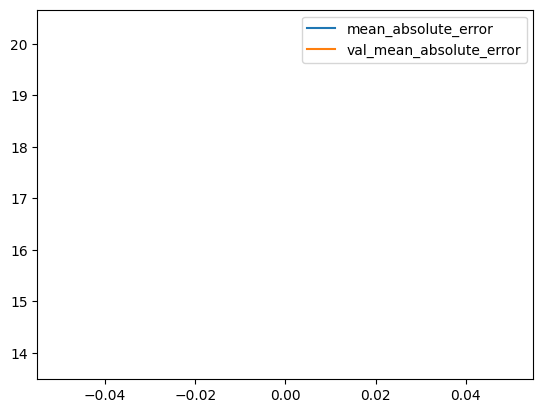

206/206 [==============================] - 47s 172ms/step - loss: 105.6130 - mean_absolute_error: 13.8101 - val_loss: 170.7082 - val_mean_absolute_error: 20.3403 - lr: 0.0050
Epoch 2/100
206/206 [==============================] - ETA: 0s - loss: 81.6811 - mean_absolute_error: 11.2852
Epoch 2: val_mean_absolute_error improved from 20.34029 to 18.58776, saving model to temp3-from-sc.keras


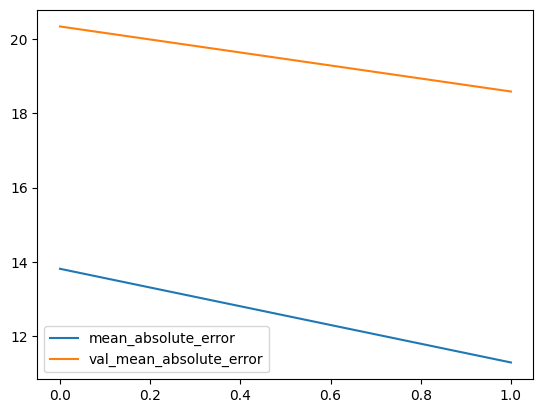

206/206 [==============================] - 21s 100ms/step - loss: 81.6811 - mean_absolute_error: 11.2852 - val_loss: 151.3113 - val_mean_absolute_error: 18.5878 - lr: 0.0050
Epoch 3/100
206/206 [==============================] - ETA: 0s - loss: 68.1657 - mean_absolute_error: 9.8598
Epoch 3: val_mean_absolute_error improved from 18.58776 to 14.03840, saving model to temp3-from-sc.keras


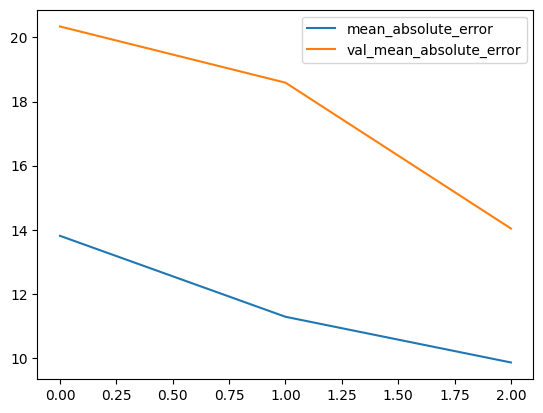

206/206 [==============================] - 21s 103ms/step - loss: 68.1657 - mean_absolute_error: 9.8598 - val_loss: 108.2134 - val_mean_absolute_error: 14.0384 - lr: 0.0050
Epoch 4/100
206/206 [==============================] - ETA: 0s - loss: 56.4382 - mean_absolute_error: 8.6034
Epoch 4: val_mean_absolute_error improved from 14.03840 to 10.27460, saving model to temp3-from-sc.keras


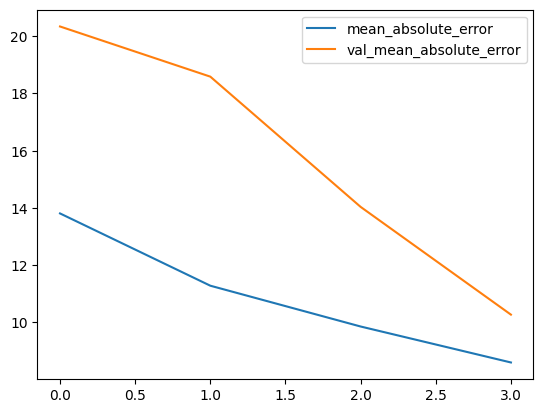

206/206 [==============================] - 21s 103ms/step - loss: 56.4382 - mean_absolute_error: 8.6034 - val_loss: 70.7991 - val_mean_absolute_error: 10.2746 - lr: 0.0050
Epoch 5/100
206/206 [==============================] - ETA: 0s - loss: 49.9493 - mean_absolute_error: 7.8768
Epoch 5: val_mean_absolute_error improved from 10.27460 to 9.66529, saving model to temp3-from-sc.keras


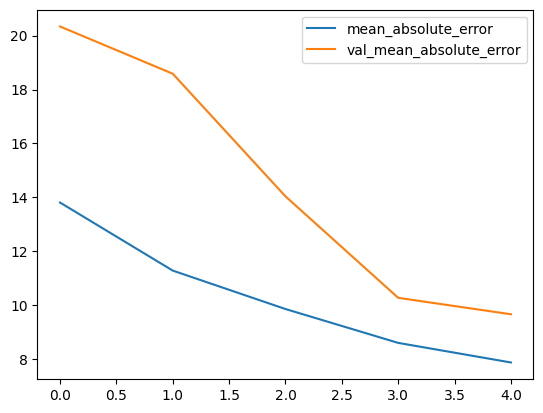

206/206 [==============================] - 21s 104ms/step - loss: 49.9493 - mean_absolute_error: 7.8768 - val_loss: 65.6244 - val_mean_absolute_error: 9.6653 - lr: 0.0050
Epoch 6/100
206/206 [==============================] - ETA: 0s - loss: 47.1309 - mean_absolute_error: 7.5619
Epoch 6: val_mean_absolute_error improved from 9.66529 to 8.57220, saving model to temp3-from-sc.keras


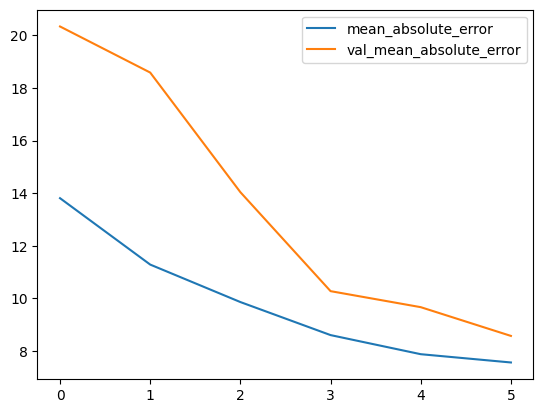

206/206 [==============================] - 22s 109ms/step - loss: 47.1309 - mean_absolute_error: 7.5619 - val_loss: 54.8642 - val_mean_absolute_error: 8.5722 - lr: 0.0050
Epoch 7/100
206/206 [==============================] - ETA: 0s - loss: 43.1947 - mean_absolute_error: 7.1087
Epoch 7: val_mean_absolute_error improved from 8.57220 to 8.25526, saving model to temp3-from-sc.keras


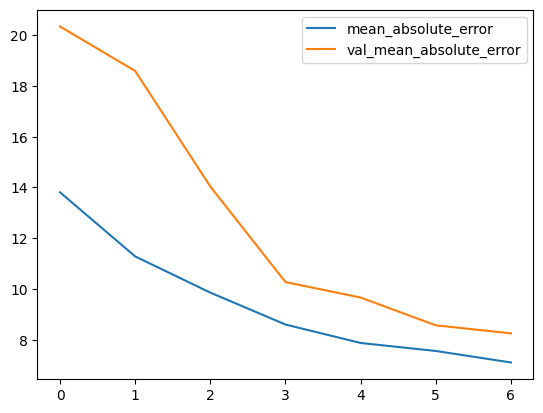

206/206 [==============================] - 24s 117ms/step - loss: 43.1947 - mean_absolute_error: 7.1087 - val_loss: 52.9764 - val_mean_absolute_error: 8.2553 - lr: 0.0050
Epoch 8/100
206/206 [==============================] - ETA: 0s - loss: 44.5026 - mean_absolute_error: 7.2954
Epoch 8: val_mean_absolute_error improved from 8.25526 to 7.89489, saving model to temp3-from-sc.keras


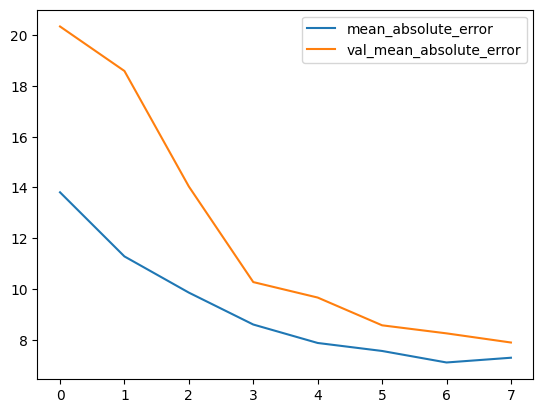

206/206 [==============================] - 23s 110ms/step - loss: 44.5026 - mean_absolute_error: 7.2954 - val_loss: 50.0455 - val_mean_absolute_error: 7.8949 - lr: 0.0050
Epoch 9/100
206/206 [==============================] - ETA: 0s - loss: 39.7009 - mean_absolute_error: 6.7162
Epoch 9: val_mean_absolute_error did not improve from 7.89489


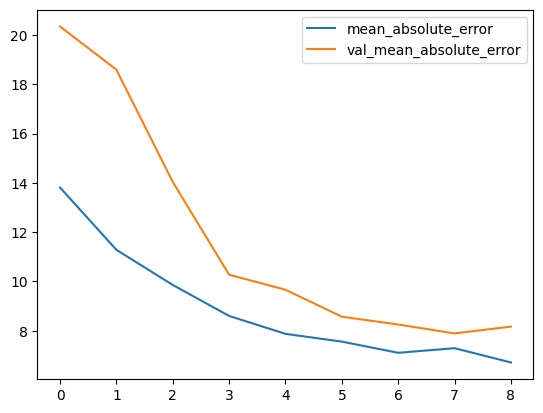

206/206 [==============================] - 21s 104ms/step - loss: 39.7009 - mean_absolute_error: 6.7162 - val_loss: 53.0841 - val_mean_absolute_error: 8.1703 - lr: 0.0050
Epoch 10/100
206/206 [==============================] - ETA: 0s - loss: 38.6264 - mean_absolute_error: 6.5826
Epoch 10: val_mean_absolute_error improved from 7.89489 to 7.73483, saving model to temp3-from-sc.keras


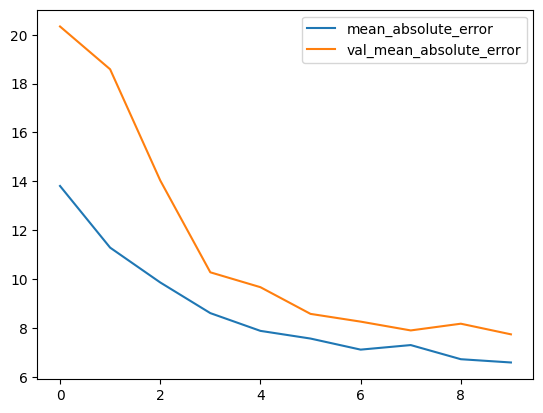

206/206 [==============================] - 22s 108ms/step - loss: 38.6264 - mean_absolute_error: 6.5826 - val_loss: 47.7402 - val_mean_absolute_error: 7.7348 - lr: 0.0050
Epoch 11/100
206/206 [==============================] - ETA: 0s - loss: 37.7104 - mean_absolute_error: 6.4901
Epoch 11: val_mean_absolute_error did not improve from 7.73483


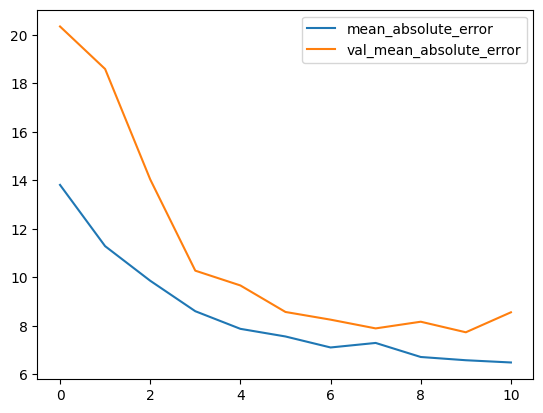

206/206 [==============================] - 21s 101ms/step - loss: 37.7104 - mean_absolute_error: 6.4901 - val_loss: 55.5684 - val_mean_absolute_error: 8.5586 - lr: 0.0050
Epoch 12/100
206/206 [==============================] - ETA: 0s - loss: 36.7027 - mean_absolute_error: 6.3903
Epoch 12: val_mean_absolute_error improved from 7.73483 to 7.62397, saving model to temp3-from-sc.keras


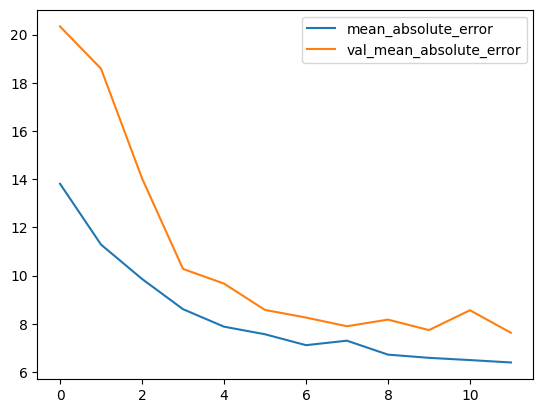

206/206 [==============================] - 21s 101ms/step - loss: 36.7027 - mean_absolute_error: 6.3903 - val_loss: 47.0174 - val_mean_absolute_error: 7.6240 - lr: 0.0050
Epoch 13/100
206/206 [==============================] - ETA: 0s - loss: 35.6440 - mean_absolute_error: 6.2433
Epoch 13: val_mean_absolute_error did not improve from 7.62397


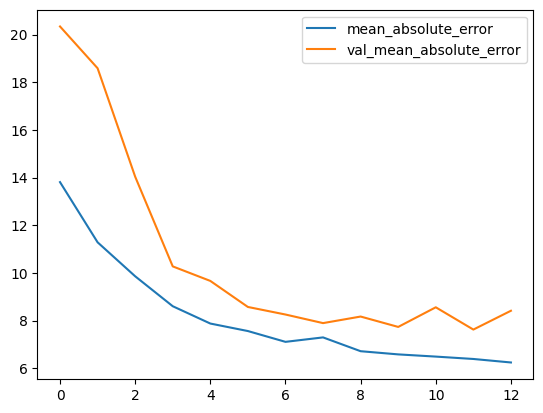

206/206 [==============================] - 22s 105ms/step - loss: 35.6440 - mean_absolute_error: 6.2433 - val_loss: 53.8438 - val_mean_absolute_error: 8.4136 - lr: 0.0050
Epoch 14/100
206/206 [==============================] - ETA: 0s - loss: 34.0222 - mean_absolute_error: 6.0435
Epoch 14: val_mean_absolute_error improved from 7.62397 to 6.86497, saving model to temp3-from-sc.keras


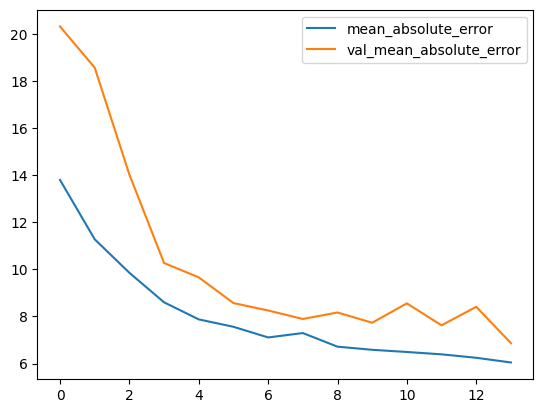

206/206 [==============================] - 21s 103ms/step - loss: 34.0222 - mean_absolute_error: 6.0435 - val_loss: 41.3389 - val_mean_absolute_error: 6.8650 - lr: 0.0050
Epoch 15/100
206/206 [==============================] - ETA: 0s - loss: 34.3678 - mean_absolute_error: 6.0929
Epoch 15: val_mean_absolute_error did not improve from 6.86497


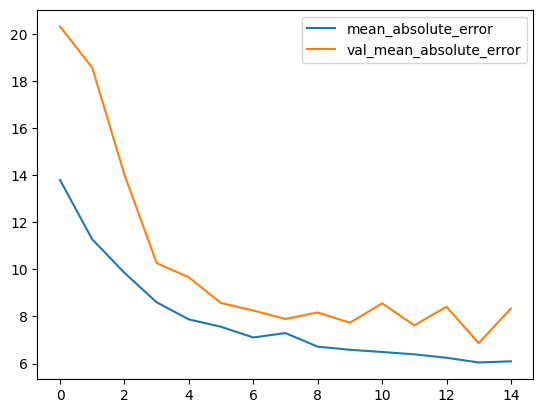

206/206 [==============================] - 21s 104ms/step - loss: 34.3678 - mean_absolute_error: 6.0929 - val_loss: 53.4050 - val_mean_absolute_error: 8.3414 - lr: 0.0050
Epoch 16/100
206/206 [==============================] - ETA: 0s - loss: 30.3857 - mean_absolute_error: 5.6292
Epoch 16: val_mean_absolute_error did not improve from 6.86497


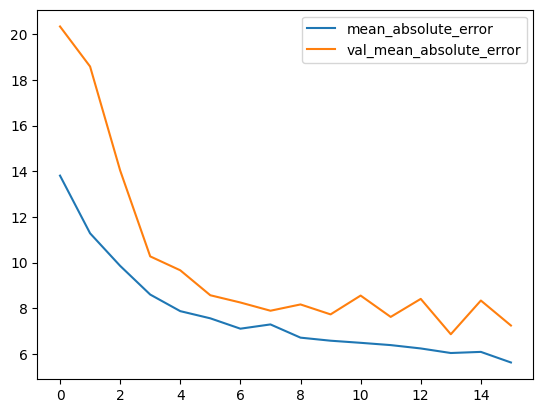

206/206 [==============================] - 21s 104ms/step - loss: 30.3857 - mean_absolute_error: 5.6292 - val_loss: 43.8813 - val_mean_absolute_error: 7.2476 - lr: 0.0050
Epoch 17/100
206/206 [==============================] - ETA: 0s - loss: 29.0879 - mean_absolute_error: 5.4411
Epoch 17: val_mean_absolute_error did not improve from 6.86497


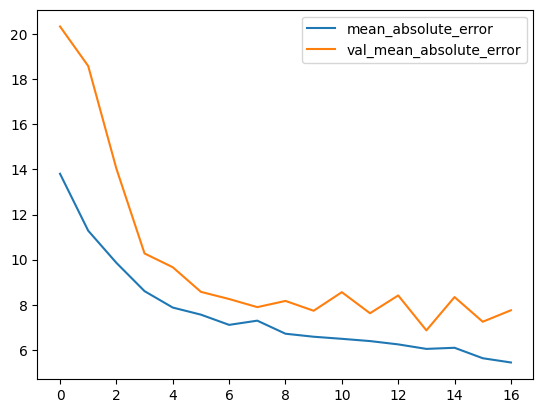

206/206 [==============================] - 21s 104ms/step - loss: 29.0879 - mean_absolute_error: 5.4411 - val_loss: 48.8166 - val_mean_absolute_error: 7.7560 - lr: 0.0050
Epoch 18/100
206/206 [==============================] - ETA: 0s - loss: 29.8105 - mean_absolute_error: 5.4920
Epoch 18: val_mean_absolute_error improved from 6.86497 to 6.59313, saving model to temp3-from-sc.keras


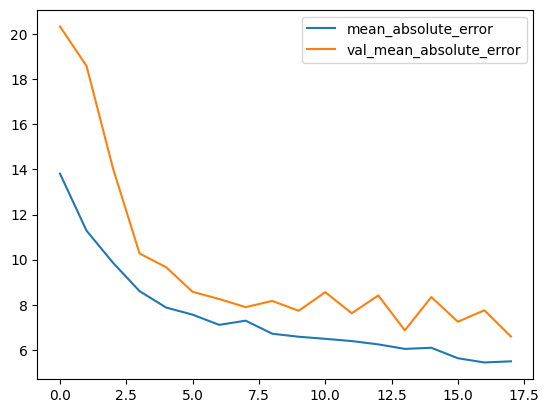

206/206 [==============================] - 22s 108ms/step - loss: 29.8105 - mean_absolute_error: 5.4920 - val_loss: 39.1763 - val_mean_absolute_error: 6.5931 - lr: 0.0050
Epoch 19/100
206/206 [==============================] - ETA: 0s - loss: 27.2424 - mean_absolute_error: 5.2337
Epoch 19: val_mean_absolute_error did not improve from 6.59313


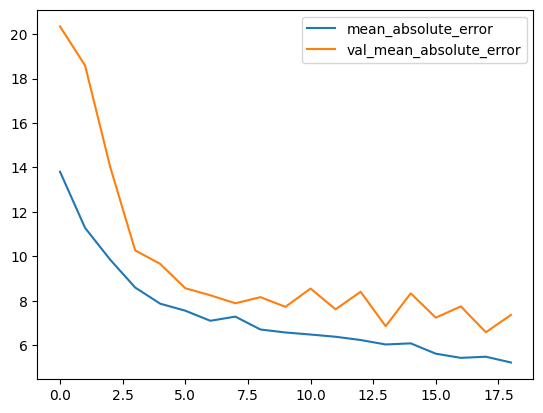

206/206 [==============================] - 21s 103ms/step - loss: 27.2424 - mean_absolute_error: 5.2337 - val_loss: 45.0781 - val_mean_absolute_error: 7.3716 - lr: 0.0050
Epoch 20/100
206/206 [==============================] - ETA: 0s - loss: 28.1641 - mean_absolute_error: 5.3244
Epoch 20: val_mean_absolute_error did not improve from 6.59313


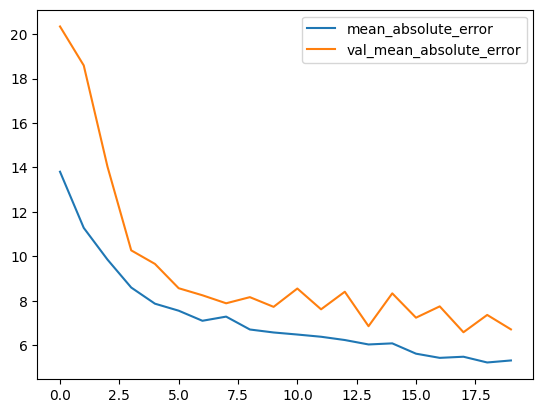

206/206 [==============================] - 21s 102ms/step - loss: 28.1641 - mean_absolute_error: 5.3244 - val_loss: 40.1194 - val_mean_absolute_error: 6.7217 - lr: 0.0050
Epoch 21/100
206/206 [==============================] - ETA: 0s - loss: 26.1805 - mean_absolute_error: 5.0713
Epoch 21: val_mean_absolute_error improved from 6.59313 to 6.44191, saving model to temp3-from-sc.keras


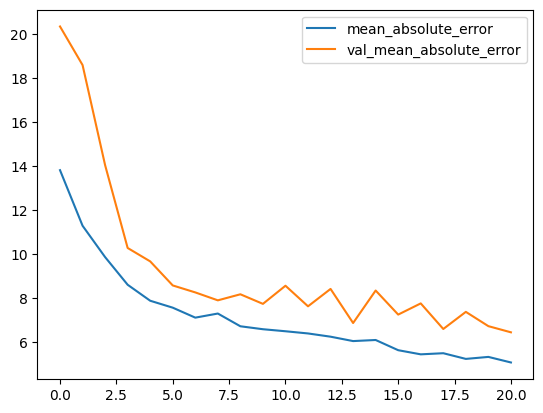

206/206 [==============================] - 21s 104ms/step - loss: 26.1805 - mean_absolute_error: 5.0713 - val_loss: 36.6821 - val_mean_absolute_error: 6.4419 - lr: 0.0050
Epoch 22/100
206/206 [==============================] - ETA: 0s - loss: 24.2521 - mean_absolute_error: 4.8451
Epoch 22: val_mean_absolute_error improved from 6.44191 to 6.44116, saving model to temp3-from-sc.keras


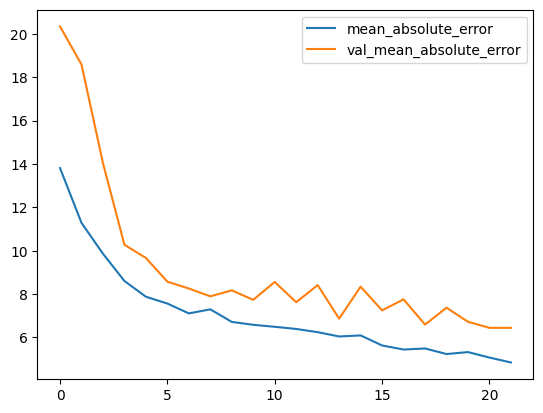

206/206 [==============================] - 21s 104ms/step - loss: 24.2521 - mean_absolute_error: 4.8451 - val_loss: 36.4388 - val_mean_absolute_error: 6.4412 - lr: 0.0050
Epoch 23/100
206/206 [==============================] - ETA: 0s - loss: 23.7042 - mean_absolute_error: 4.7801
Epoch 23: val_mean_absolute_error did not improve from 6.44116


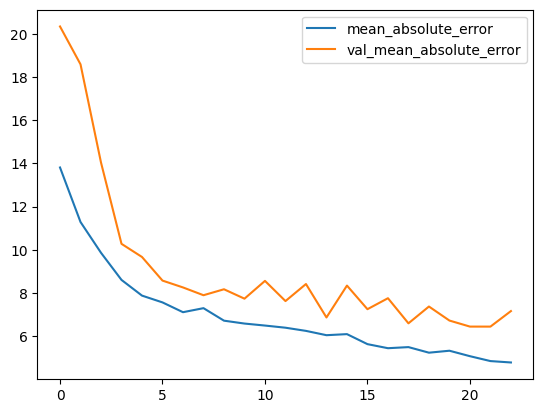

206/206 [==============================] - 24s 118ms/step - loss: 23.7042 - mean_absolute_error: 4.7801 - val_loss: 42.4193 - val_mean_absolute_error: 7.1608 - lr: 0.0050
Epoch 24/100
206/206 [==============================] - ETA: 0s - loss: 24.2982 - mean_absolute_error: 4.8222
Epoch 24: val_mean_absolute_error did not improve from 6.44116


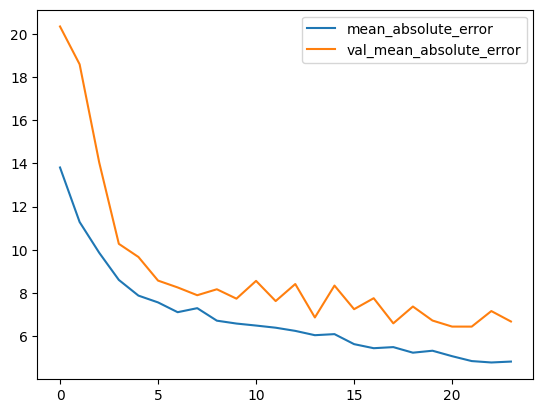

206/206 [==============================] - 22s 108ms/step - loss: 24.2982 - mean_absolute_error: 4.8222 - val_loss: 38.8730 - val_mean_absolute_error: 6.6781 - lr: 0.0050
Epoch 25/100
206/206 [==============================] - ETA: 0s - loss: 24.4262 - mean_absolute_error: 4.8377
Epoch 25: val_mean_absolute_error improved from 6.44116 to 6.25460, saving model to temp3-from-sc.keras


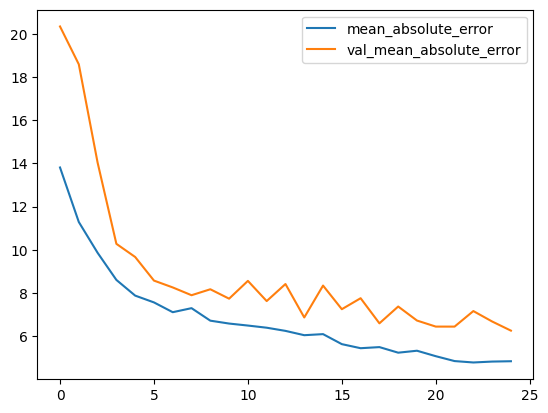

206/206 [==============================] - 22s 105ms/step - loss: 24.4262 - mean_absolute_error: 4.8377 - val_loss: 35.7753 - val_mean_absolute_error: 6.2546 - lr: 0.0050
Epoch 26/100
206/206 [==============================] - ETA: 0s - loss: 23.1076 - mean_absolute_error: 4.6711
Epoch 26: val_mean_absolute_error did not improve from 6.25460


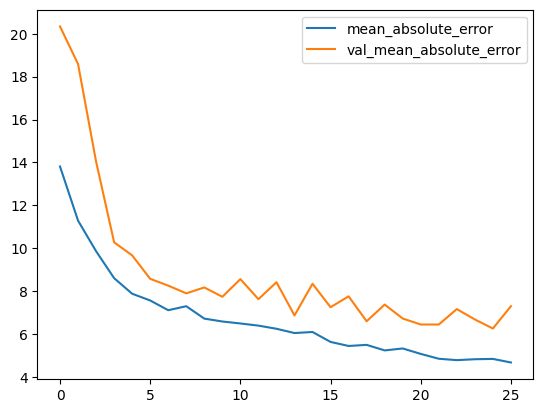

206/206 [==============================] - 21s 101ms/step - loss: 23.1076 - mean_absolute_error: 4.6711 - val_loss: 45.3264 - val_mean_absolute_error: 7.2964 - lr: 0.0050
Epoch 27/100
206/206 [==============================] - ETA: 0s - loss: 24.8405 - mean_absolute_error: 4.8775
Epoch 27: val_mean_absolute_error did not improve from 6.25460


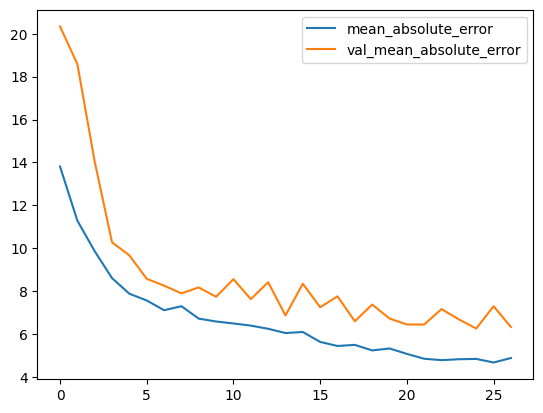

206/206 [==============================] - 21s 102ms/step - loss: 24.8405 - mean_absolute_error: 4.8775 - val_loss: 35.9464 - val_mean_absolute_error: 6.3248 - lr: 0.0050
Epoch 28/100
206/206 [==============================] - ETA: 0s - loss: 22.0952 - mean_absolute_error: 4.5470
Epoch 28: val_mean_absolute_error improved from 6.25460 to 6.06096, saving model to temp3-from-sc.keras


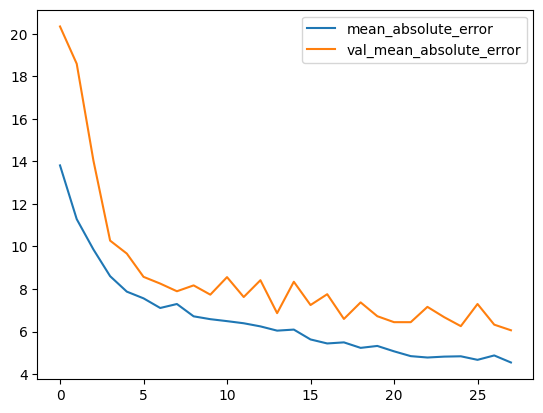

206/206 [==============================] - 21s 101ms/step - loss: 22.0952 - mean_absolute_error: 4.5470 - val_loss: 34.5398 - val_mean_absolute_error: 6.0610 - lr: 0.0050
Epoch 29/100
206/206 [==============================] - ETA: 0s - loss: 22.9630 - mean_absolute_error: 4.6277
Epoch 29: val_mean_absolute_error did not improve from 6.06096


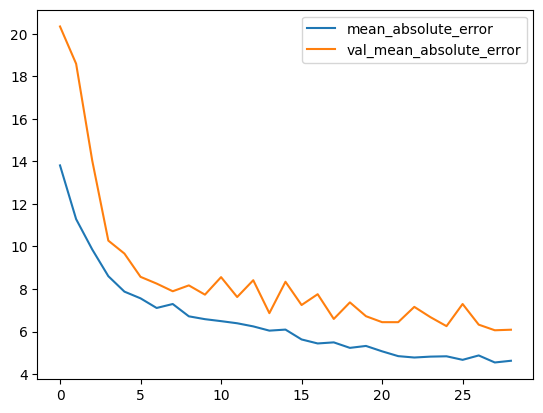

206/206 [==============================] - 21s 103ms/step - loss: 22.9630 - mean_absolute_error: 4.6277 - val_loss: 34.5742 - val_mean_absolute_error: 6.0870 - lr: 0.0050
Epoch 30/100
206/206 [==============================] - ETA: 0s - loss: 21.5194 - mean_absolute_error: 4.4349
Epoch 30: val_mean_absolute_error improved from 6.06096 to 6.01523, saving model to temp3-from-sc.keras


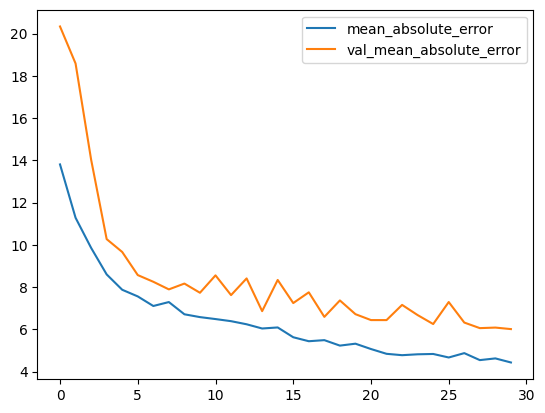

206/206 [==============================] - 22s 105ms/step - loss: 21.5194 - mean_absolute_error: 4.4349 - val_loss: 32.8922 - val_mean_absolute_error: 6.0152 - lr: 0.0050
Epoch 31/100
206/206 [==============================] - ETA: 0s - loss: 20.7942 - mean_absolute_error: 4.3727
Epoch 31: val_mean_absolute_error did not improve from 6.01523


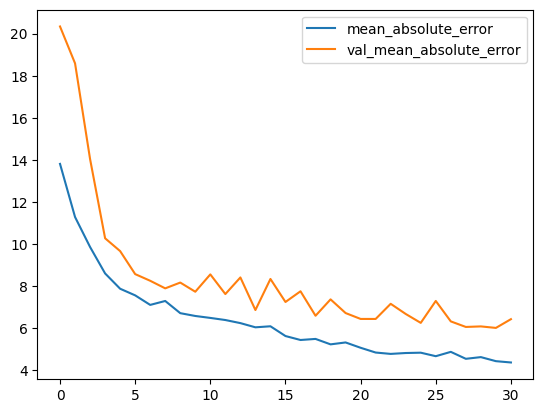

206/206 [==============================] - 22s 105ms/step - loss: 20.7942 - mean_absolute_error: 4.3727 - val_loss: 37.1500 - val_mean_absolute_error: 6.4309 - lr: 0.0050
Epoch 32/100
206/206 [==============================] - ETA: 0s - loss: 20.1525 - mean_absolute_error: 4.3023
Epoch 32: val_mean_absolute_error did not improve from 6.01523


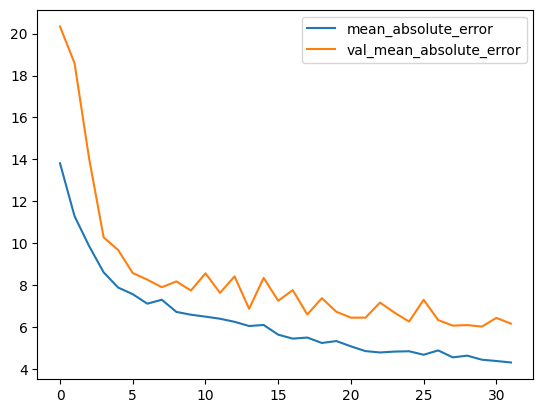

206/206 [==============================] - 21s 104ms/step - loss: 20.1525 - mean_absolute_error: 4.3023 - val_loss: 33.9389 - val_mean_absolute_error: 6.1568 - lr: 0.0050
Epoch 33/100
206/206 [==============================] - ETA: 0s - loss: 19.3707 - mean_absolute_error: 4.1906
Epoch 33: val_mean_absolute_error improved from 6.01523 to 5.90426, saving model to temp3-from-sc.keras


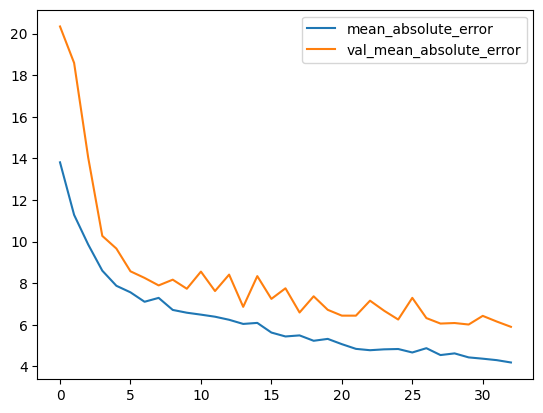

206/206 [==============================] - 21s 102ms/step - loss: 19.3707 - mean_absolute_error: 4.1906 - val_loss: 32.4935 - val_mean_absolute_error: 5.9043 - lr: 0.0050
Epoch 34/100
206/206 [==============================] - ETA: 0s - loss: 21.1848 - mean_absolute_error: 4.3979
Epoch 34: val_mean_absolute_error improved from 5.90426 to 5.78802, saving model to temp3-from-sc.keras


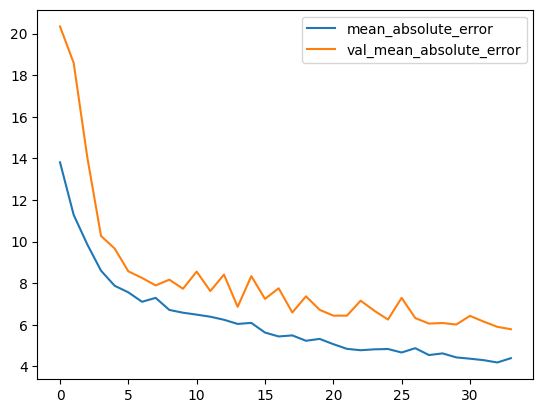

206/206 [==============================] - 22s 107ms/step - loss: 21.1848 - mean_absolute_error: 4.3979 - val_loss: 32.1171 - val_mean_absolute_error: 5.7880 - lr: 0.0050
Epoch 35/100
206/206 [==============================] - ETA: 0s - loss: 19.2232 - mean_absolute_error: 4.1633
Epoch 35: val_mean_absolute_error improved from 5.78802 to 5.67634, saving model to temp3-from-sc.keras


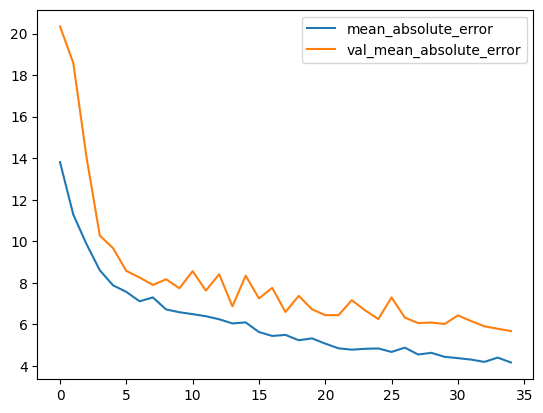

206/206 [==============================] - 22s 104ms/step - loss: 19.2232 - mean_absolute_error: 4.1633 - val_loss: 31.1809 - val_mean_absolute_error: 5.6763 - lr: 0.0050
Epoch 36/100
206/206 [==============================] - ETA: 0s - loss: 18.8907 - mean_absolute_error: 4.1203
Epoch 36: val_mean_absolute_error did not improve from 5.67634


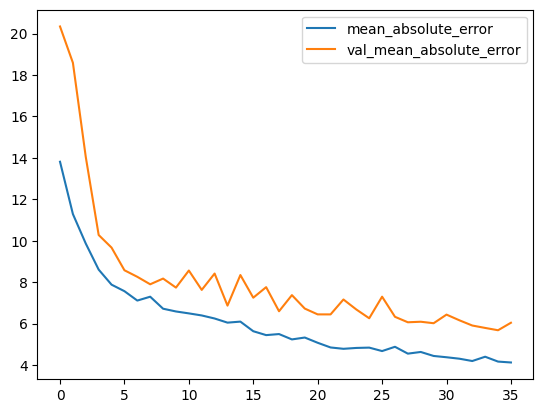

206/206 [==============================] - 21s 102ms/step - loss: 18.8907 - mean_absolute_error: 4.1203 - val_loss: 34.0974 - val_mean_absolute_error: 6.0380 - lr: 0.0050
Epoch 37/100
206/206 [==============================] - ETA: 0s - loss: 19.0788 - mean_absolute_error: 4.1285
Epoch 37: val_mean_absolute_error did not improve from 5.67634


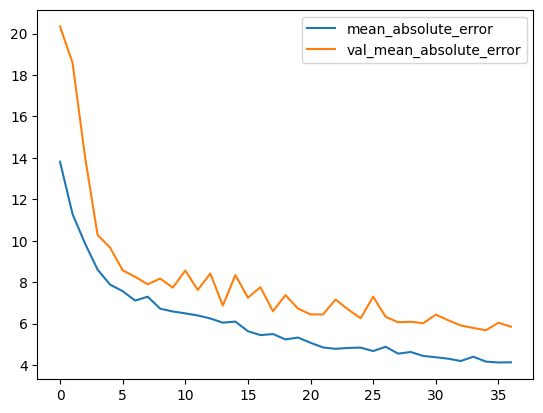

206/206 [==============================] - 23s 110ms/step - loss: 19.0788 - mean_absolute_error: 4.1285 - val_loss: 32.7260 - val_mean_absolute_error: 5.8471 - lr: 0.0050
Epoch 38/100
206/206 [==============================] - ETA: 0s - loss: 18.8787 - mean_absolute_error: 4.0820
Epoch 38: val_mean_absolute_error did not improve from 5.67634


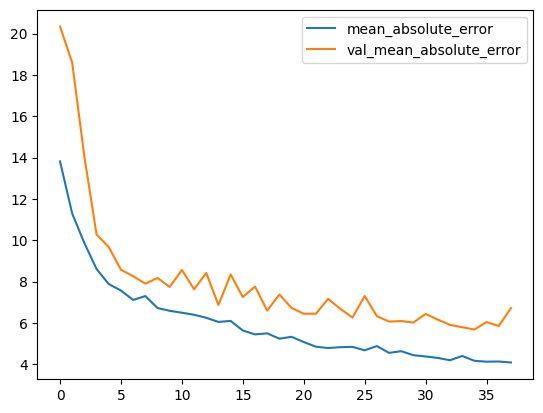

206/206 [==============================] - 23s 111ms/step - loss: 18.8787 - mean_absolute_error: 4.0820 - val_loss: 39.9940 - val_mean_absolute_error: 6.7125 - lr: 0.0050
Epoch 39/100
206/206 [==============================] - ETA: 0s - loss: 17.7788 - mean_absolute_error: 3.9566
Epoch 39: val_mean_absolute_error did not improve from 5.67634


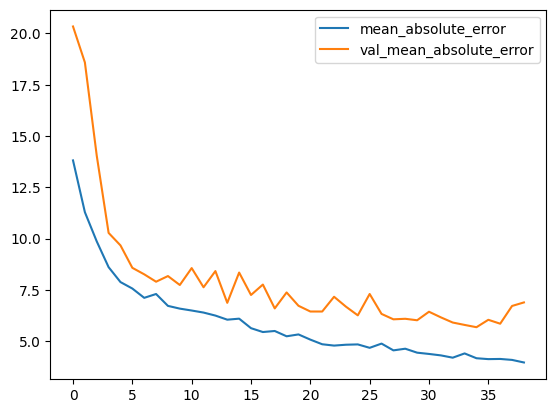

206/206 [==============================] - 24s 116ms/step - loss: 17.7788 - mean_absolute_error: 3.9566 - val_loss: 41.7329 - val_mean_absolute_error: 6.8850 - lr: 0.0050
Epoch 40/100
206/206 [==============================] - ETA: 0s - loss: 19.1087 - mean_absolute_error: 4.1478
Epoch 40: val_mean_absolute_error did not improve from 5.67634


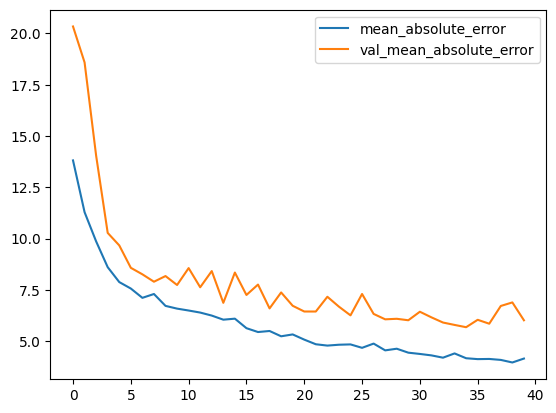

206/206 [==============================] - 27s 133ms/step - loss: 19.1087 - mean_absolute_error: 4.1478 - val_loss: 33.4363 - val_mean_absolute_error: 6.0141 - lr: 0.0050
Epoch 41/100
206/206 [==============================] - ETA: 0s - loss: 14.3557 - mean_absolute_error: 3.4636
Epoch 41: val_mean_absolute_error improved from 5.67634 to 5.38274, saving model to temp3-from-sc.keras


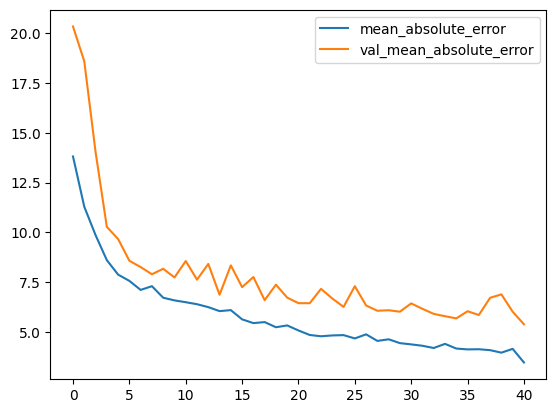

206/206 [==============================] - 26s 124ms/step - loss: 14.3557 - mean_absolute_error: 3.4636 - val_loss: 28.6574 - val_mean_absolute_error: 5.3827 - lr: 1.0000e-03
Epoch 42/100
206/206 [==============================] - ETA: 0s - loss: 12.9260 - mean_absolute_error: 3.2415
Epoch 42: val_mean_absolute_error improved from 5.38274 to 5.24929, saving model to temp3-from-sc.keras


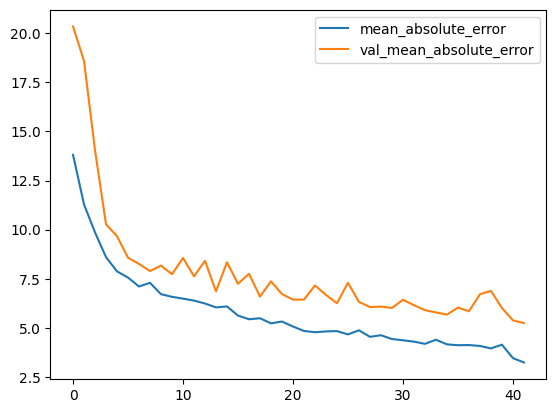

206/206 [==============================] - 26s 125ms/step - loss: 12.9260 - mean_absolute_error: 3.2415 - val_loss: 28.0109 - val_mean_absolute_error: 5.2493 - lr: 1.0000e-03
Epoch 43/100
206/206 [==============================] - ETA: 0s - loss: 13.0378 - mean_absolute_error: 3.2427
Epoch 43: val_mean_absolute_error improved from 5.24929 to 5.21896, saving model to temp3-from-sc.keras


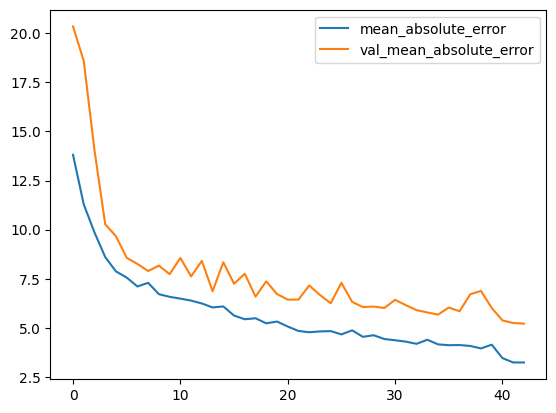

206/206 [==============================] - 28s 134ms/step - loss: 13.0378 - mean_absolute_error: 3.2427 - val_loss: 27.7638 - val_mean_absolute_error: 5.2190 - lr: 1.0000e-03
Epoch 44/100
206/206 [==============================] - ETA: 0s - loss: 12.3989 - mean_absolute_error: 3.1303
Epoch 44: val_mean_absolute_error improved from 5.21896 to 5.17969, saving model to temp3-from-sc.keras


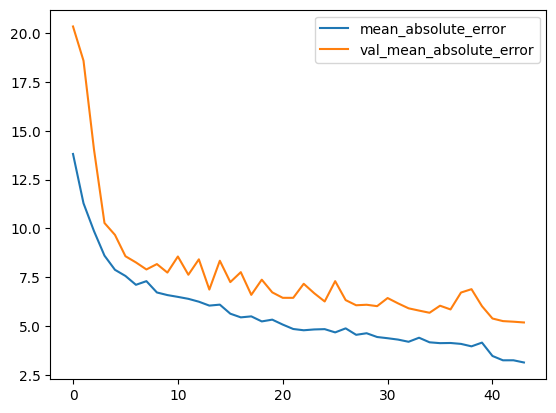

206/206 [==============================] - 29s 140ms/step - loss: 12.3989 - mean_absolute_error: 3.1303 - val_loss: 27.3940 - val_mean_absolute_error: 5.1797 - lr: 1.0000e-03
Epoch 45/100
206/206 [==============================] - ETA: 0s - loss: 11.8398 - mean_absolute_error: 3.0632
Epoch 45: val_mean_absolute_error did not improve from 5.17969


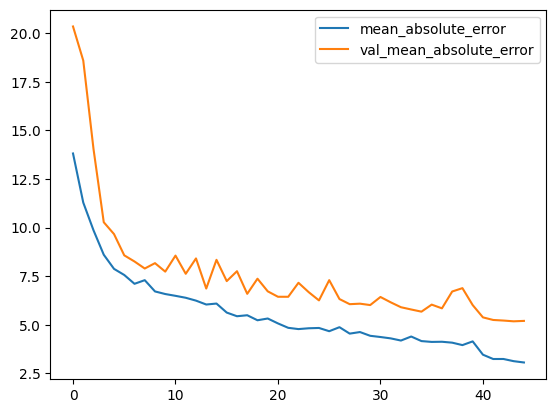

206/206 [==============================] - 27s 129ms/step - loss: 11.8398 - mean_absolute_error: 3.0632 - val_loss: 27.3654 - val_mean_absolute_error: 5.2011 - lr: 1.0000e-03
Epoch 46/100
206/206 [==============================] - ETA: 0s - loss: 11.6138 - mean_absolute_error: 3.0023
Epoch 46: val_mean_absolute_error improved from 5.17969 to 5.10732, saving model to temp3-from-sc.keras


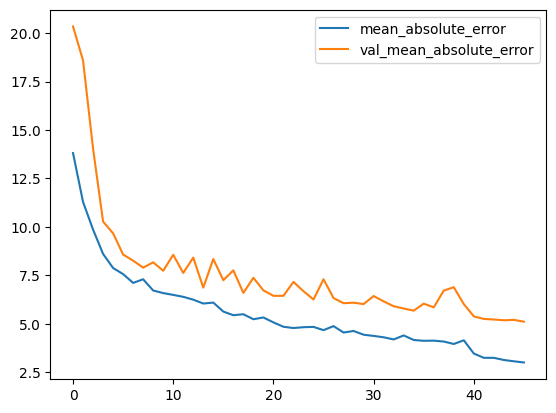

206/206 [==============================] - 27s 129ms/step - loss: 11.6138 - mean_absolute_error: 3.0023 - val_loss: 26.7943 - val_mean_absolute_error: 5.1073 - lr: 1.0000e-03
Epoch 47/100
206/206 [==============================] - ETA: 0s - loss: 11.6233 - mean_absolute_error: 3.0136
Epoch 47: val_mean_absolute_error did not improve from 5.10732


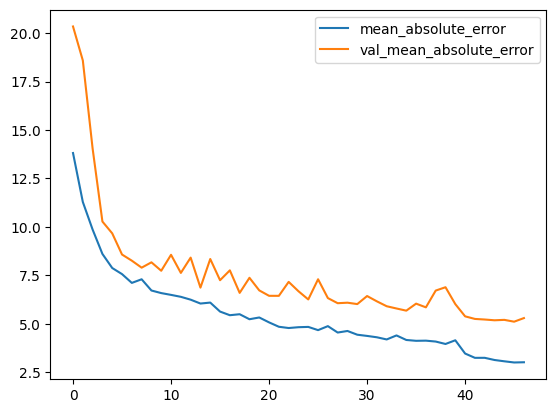

206/206 [==============================] - 26s 125ms/step - loss: 11.6233 - mean_absolute_error: 3.0136 - val_loss: 28.5848 - val_mean_absolute_error: 5.2935 - lr: 1.0000e-03
Epoch 48/100
206/206 [==============================] - ETA: 0s - loss: 10.7880 - mean_absolute_error: 2.8747
Epoch 48: val_mean_absolute_error did not improve from 5.10732


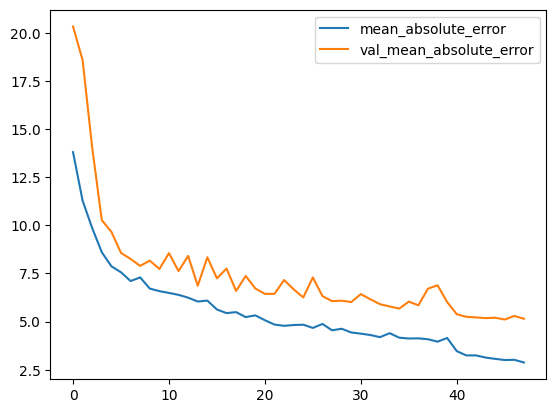

206/206 [==============================] - 26s 125ms/step - loss: 10.7880 - mean_absolute_error: 2.8747 - val_loss: 26.9987 - val_mean_absolute_error: 5.1474 - lr: 1.0000e-03
Epoch 49/100
206/206 [==============================] - ETA: 0s - loss: 11.6487 - mean_absolute_error: 3.0157
Epoch 49: val_mean_absolute_error did not improve from 5.10732


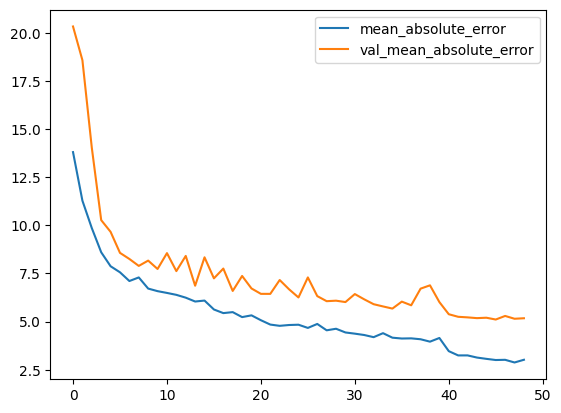

206/206 [==============================] - 26s 125ms/step - loss: 11.6487 - mean_absolute_error: 3.0157 - val_loss: 27.1871 - val_mean_absolute_error: 5.1737 - lr: 1.0000e-03
Epoch 50/100
206/206 [==============================] - ETA: 0s - loss: 10.7072 - mean_absolute_error: 2.8790
Epoch 50: val_mean_absolute_error did not improve from 5.10732


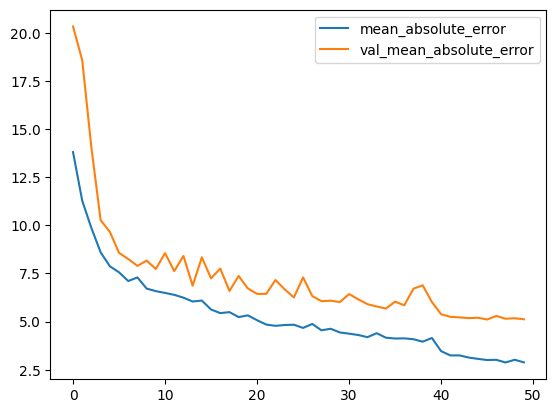

206/206 [==============================] - 26s 124ms/step - loss: 10.7072 - mean_absolute_error: 2.8790 - val_loss: 27.1492 - val_mean_absolute_error: 5.1203 - lr: 1.0000e-03
Epoch 51/100
206/206 [==============================] - ETA: 0s - loss: 10.5444 - mean_absolute_error: 2.8134
Epoch 51: val_mean_absolute_error did not improve from 5.10732


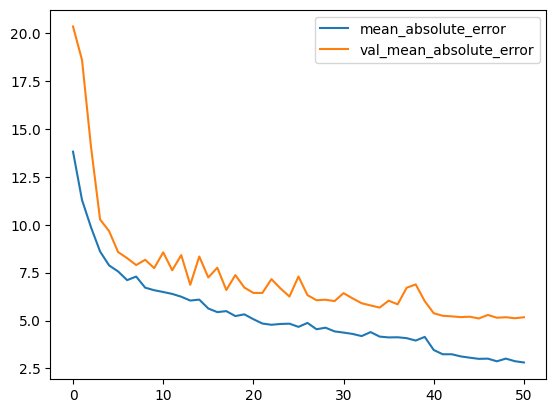

206/206 [==============================] - 26s 125ms/step - loss: 10.5444 - mean_absolute_error: 2.8134 - val_loss: 27.0464 - val_mean_absolute_error: 5.1726 - lr: 1.0000e-03
Epoch 52/100
206/206 [==============================] - ETA: 0s - loss: 9.7833 - mean_absolute_error: 2.7174
Epoch 52: val_mean_absolute_error improved from 5.10732 to 5.06126, saving model to temp3-from-sc.keras


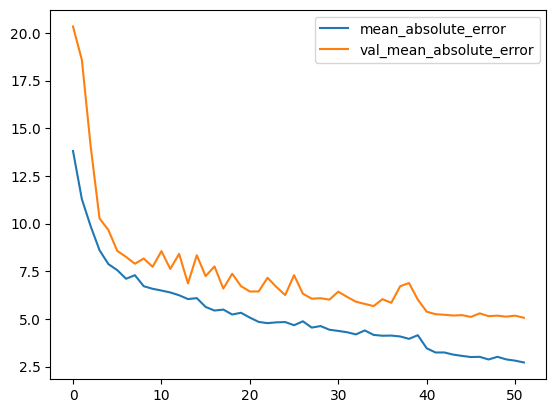

206/206 [==============================] - 26s 126ms/step - loss: 9.7833 - mean_absolute_error: 2.7174 - val_loss: 26.4302 - val_mean_absolute_error: 5.0613 - lr: 2.0000e-04
Epoch 53/100
206/206 [==============================] - ETA: 0s - loss: 9.7697 - mean_absolute_error: 2.6957
Epoch 53: val_mean_absolute_error improved from 5.06126 to 5.06082, saving model to temp3-from-sc.keras


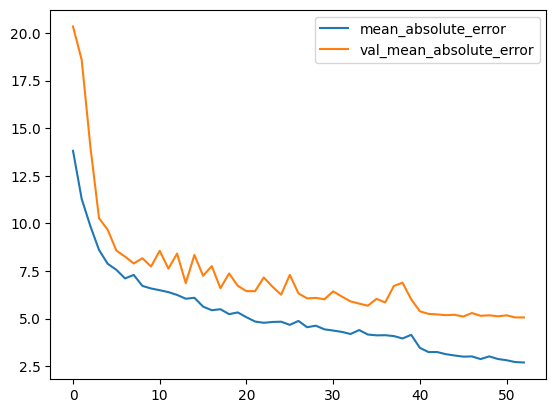

206/206 [==============================] - 26s 125ms/step - loss: 9.7697 - mean_absolute_error: 2.6957 - val_loss: 26.3814 - val_mean_absolute_error: 5.0608 - lr: 2.0000e-04
Epoch 54/100
206/206 [==============================] - ETA: 0s - loss: 9.3946 - mean_absolute_error: 2.6266
Epoch 54: val_mean_absolute_error improved from 5.06082 to 5.05124, saving model to temp3-from-sc.keras


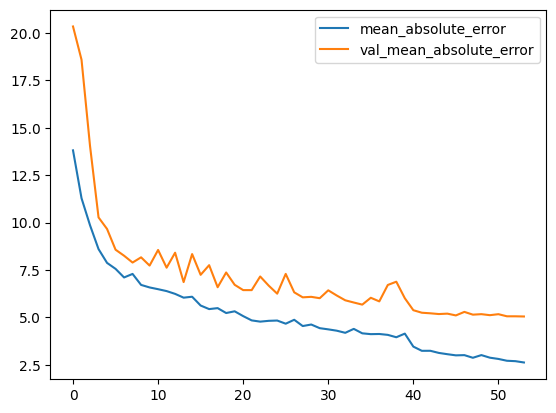

206/206 [==============================] - 26s 125ms/step - loss: 9.3946 - mean_absolute_error: 2.6266 - val_loss: 26.3401 - val_mean_absolute_error: 5.0512 - lr: 2.0000e-04
Epoch 55/100
206/206 [==============================] - ETA: 0s - loss: 9.5348 - mean_absolute_error: 2.6456
Epoch 55: val_mean_absolute_error improved from 5.05124 to 5.03131, saving model to temp3-from-sc.keras


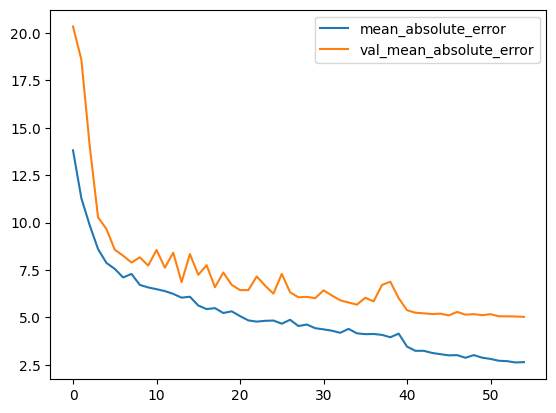

206/206 [==============================] - 29s 138ms/step - loss: 9.5348 - mean_absolute_error: 2.6456 - val_loss: 26.1650 - val_mean_absolute_error: 5.0313 - lr: 2.0000e-04
Epoch 56/100
206/206 [==============================] - ETA: 0s - loss: 9.5284 - mean_absolute_error: 2.6381
Epoch 56: val_mean_absolute_error did not improve from 5.03131


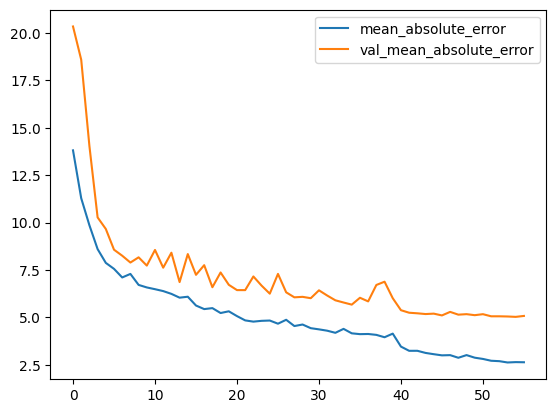

206/206 [==============================] - 29s 142ms/step - loss: 9.5284 - mean_absolute_error: 2.6381 - val_loss: 26.5491 - val_mean_absolute_error: 5.0804 - lr: 2.0000e-04
Epoch 57/100
206/206 [==============================] - ETA: 0s - loss: 9.4355 - mean_absolute_error: 2.6148
Epoch 57: val_mean_absolute_error did not improve from 5.03131


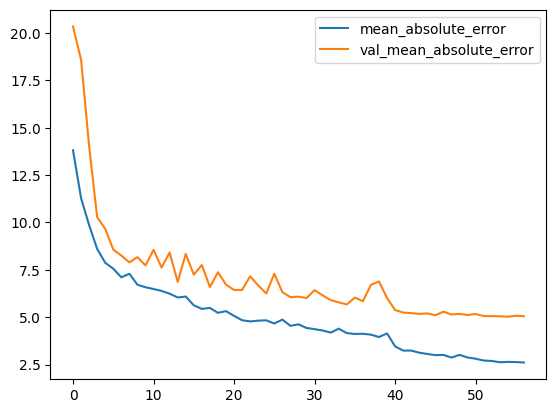

206/206 [==============================] - 28s 133ms/step - loss: 9.4355 - mean_absolute_error: 2.6148 - val_loss: 26.3039 - val_mean_absolute_error: 5.0534 - lr: 2.0000e-04
Epoch 58/100
206/206 [==============================] - ETA: 0s - loss: 9.4747 - mean_absolute_error: 2.6418
Epoch 58: val_mean_absolute_error did not improve from 5.03131


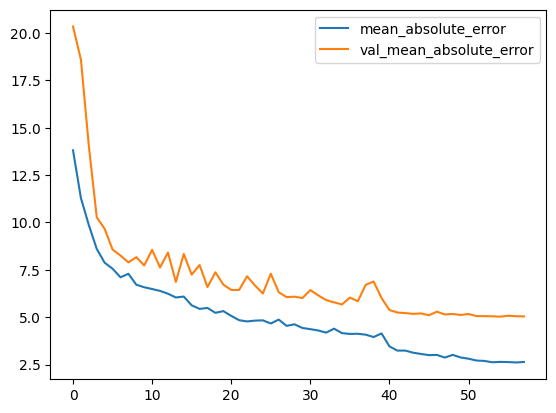

206/206 [==============================] - 28s 134ms/step - loss: 9.4747 - mean_absolute_error: 2.6418 - val_loss: 26.3860 - val_mean_absolute_error: 5.0454 - lr: 2.0000e-04
Epoch 59/100
206/206 [==============================] - ETA: 0s - loss: 9.3034 - mean_absolute_error: 2.6199
Epoch 59: val_mean_absolute_error improved from 5.03131 to 5.03042, saving model to temp3-from-sc.keras


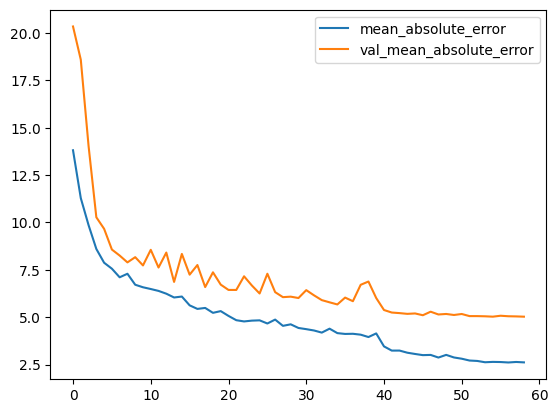

206/206 [==============================] - 27s 132ms/step - loss: 9.3034 - mean_absolute_error: 2.6199 - val_loss: 26.2151 - val_mean_absolute_error: 5.0304 - lr: 2.0000e-04
Epoch 60/100
206/206 [==============================] - ETA: 0s - loss: 8.9110 - mean_absolute_error: 2.5337
Epoch 60: val_mean_absolute_error did not improve from 5.03042


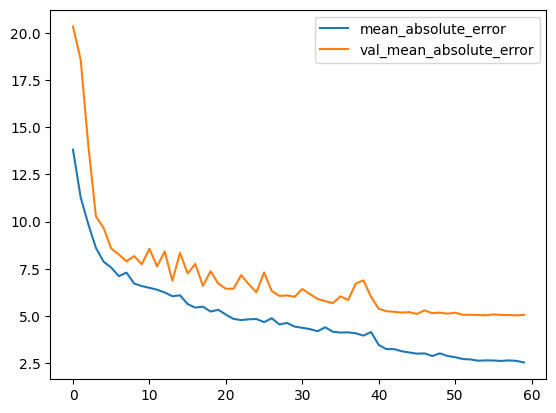

206/206 [==============================] - 27s 132ms/step - loss: 8.9110 - mean_absolute_error: 2.5337 - val_loss: 26.3336 - val_mean_absolute_error: 5.0567 - lr: 2.0000e-04
Epoch 61/100
206/206 [==============================] - ETA: 0s - loss: 9.4948 - mean_absolute_error: 2.6057
Epoch 61: val_mean_absolute_error did not improve from 5.03042


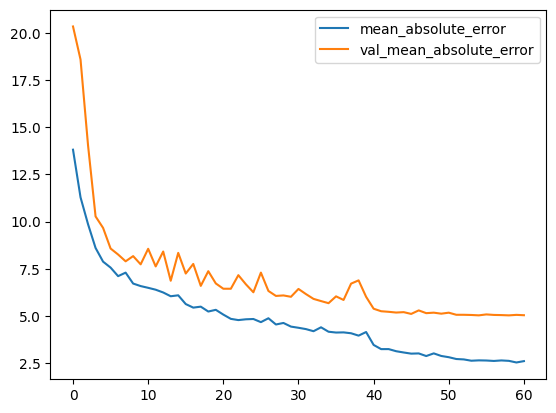

206/206 [==============================] - 27s 132ms/step - loss: 9.4948 - mean_absolute_error: 2.6057 - val_loss: 26.1719 - val_mean_absolute_error: 5.0380 - lr: 1.0000e-04
Epoch 62/100
206/206 [==============================] - ETA: 0s - loss: 9.0201 - mean_absolute_error: 2.5646
Epoch 62: val_mean_absolute_error did not improve from 5.03042


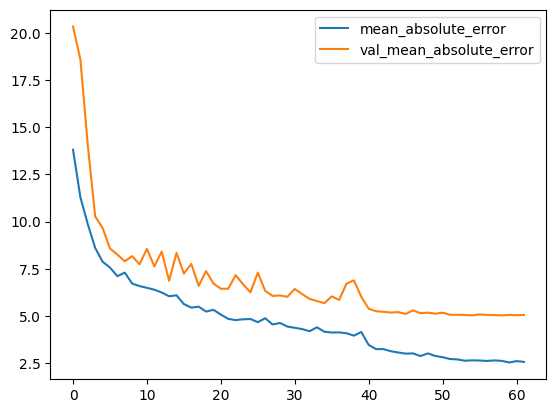

206/206 [==============================] - 27s 132ms/step - loss: 9.0201 - mean_absolute_error: 2.5646 - val_loss: 26.2898 - val_mean_absolute_error: 5.0507 - lr: 1.0000e-04
Epoch 63/100
206/206 [==============================] - ETA: 0s - loss: 9.4492 - mean_absolute_error: 2.6402
Epoch 63: val_mean_absolute_error did not improve from 5.03042


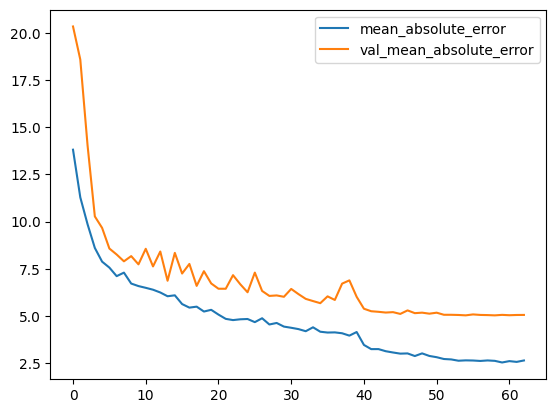

206/206 [==============================] - 27s 132ms/step - loss: 9.4492 - mean_absolute_error: 2.6402 - val_loss: 26.3513 - val_mean_absolute_error: 5.0536 - lr: 1.0000e-04
Epoch 64/100
206/206 [==============================] - ETA: 0s - loss: 9.1797 - mean_absolute_error: 2.5859
Epoch 64: val_mean_absolute_error did not improve from 5.03042


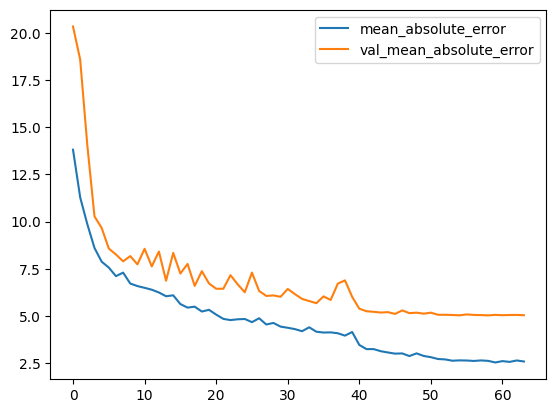

206/206 [==============================] - 27s 132ms/step - loss: 9.1797 - mean_absolute_error: 2.5859 - val_loss: 26.2283 - val_mean_absolute_error: 5.0378 - lr: 1.0000e-04
Epoch 65/100
206/206 [==============================] - ETA: 0s - loss: 9.3065 - mean_absolute_error: 2.5850
Epoch 65: val_mean_absolute_error did not improve from 5.03042


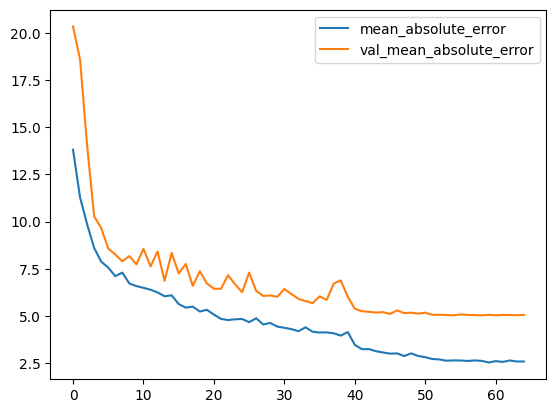

206/206 [==============================] - 27s 131ms/step - loss: 9.3065 - mean_absolute_error: 2.5850 - val_loss: 26.2750 - val_mean_absolute_error: 5.0508 - lr: 1.0000e-04
Epoch 66/100
206/206 [==============================] - ETA: 0s - loss: 8.9356 - mean_absolute_error: 2.5406
Epoch 66: val_mean_absolute_error did not improve from 5.03042


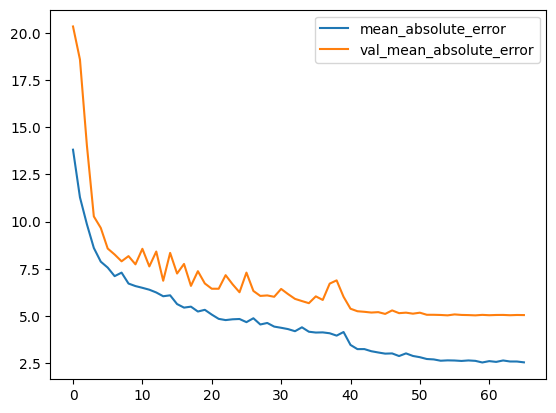

206/206 [==============================] - 27s 132ms/step - loss: 8.9356 - mean_absolute_error: 2.5406 - val_loss: 26.2429 - val_mean_absolute_error: 5.0457 - lr: 1.0000e-04
Epoch 67/100
206/206 [==============================] - ETA: 0s - loss: 9.2063 - mean_absolute_error: 2.5833
Epoch 67: val_mean_absolute_error did not improve from 5.03042


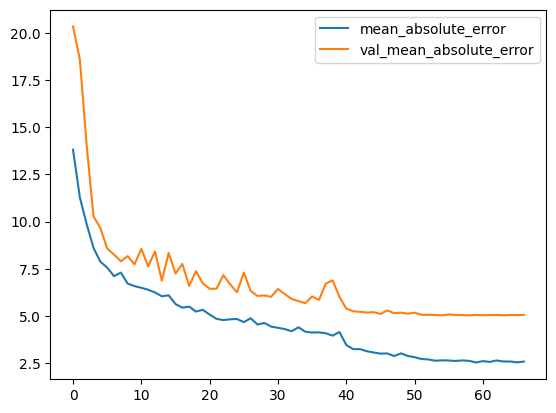

206/206 [==============================] - 27s 132ms/step - loss: 9.2063 - mean_absolute_error: 2.5833 - val_loss: 26.3145 - val_mean_absolute_error: 5.0566 - lr: 1.0000e-04
Epoch 68/100
206/206 [==============================] - ETA: 0s - loss: 9.0595 - mean_absolute_error: 2.5568
Epoch 68: val_mean_absolute_error improved from 5.03042 to 5.02781, saving model to temp3-from-sc.keras


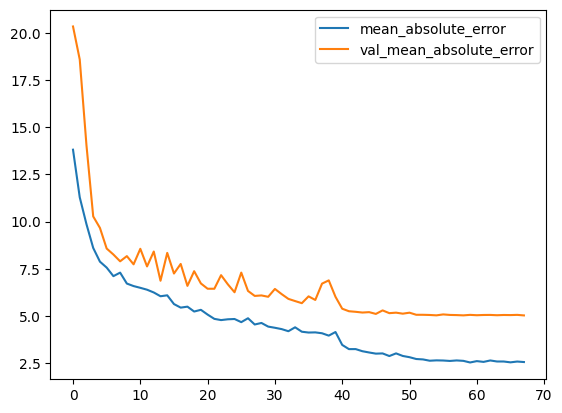

206/206 [==============================] - 27s 132ms/step - loss: 9.0595 - mean_absolute_error: 2.5568 - val_loss: 26.1770 - val_mean_absolute_error: 5.0278 - lr: 1.0000e-04
Epoch 69/100
206/206 [==============================] - ETA: 0s - loss: 9.5597 - mean_absolute_error: 2.6292
Epoch 69: val_mean_absolute_error improved from 5.02781 to 5.02478, saving model to temp3-from-sc.keras


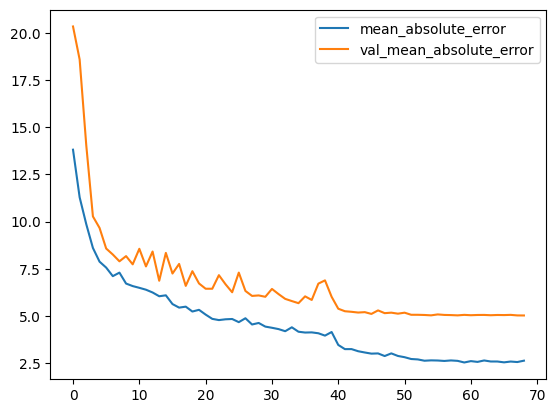

206/206 [==============================] - 27s 132ms/step - loss: 9.5597 - mean_absolute_error: 2.6292 - val_loss: 26.1376 - val_mean_absolute_error: 5.0248 - lr: 1.0000e-04
Epoch 70/100
206/206 [==============================] - ETA: 0s - loss: 9.4287 - mean_absolute_error: 2.6227
Epoch 70: val_mean_absolute_error did not improve from 5.02478


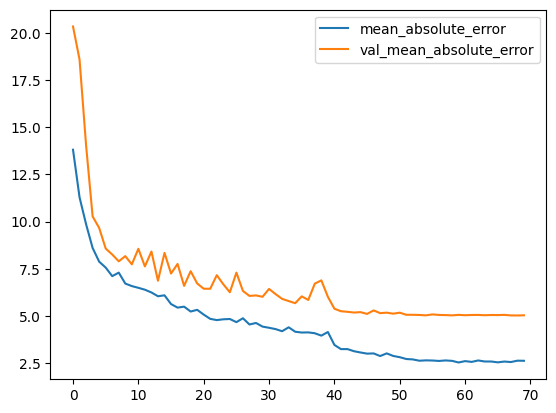

206/206 [==============================] - 27s 132ms/step - loss: 9.4287 - mean_absolute_error: 2.6227 - val_loss: 26.1562 - val_mean_absolute_error: 5.0332 - lr: 1.0000e-04
Epoch 71/100
206/206 [==============================] - ETA: 0s - loss: 9.1785 - mean_absolute_error: 2.5903
Epoch 71: val_mean_absolute_error did not improve from 5.02478


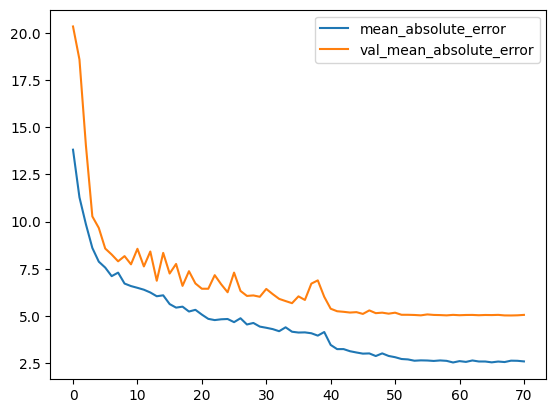

206/206 [==============================] - 27s 132ms/step - loss: 9.1785 - mean_absolute_error: 2.5903 - val_loss: 26.2601 - val_mean_absolute_error: 5.0554 - lr: 1.0000e-04
Epoch 72/100
206/206 [==============================] - ETA: 0s - loss: 9.2222 - mean_absolute_error: 2.5983
Epoch 72: val_mean_absolute_error did not improve from 5.02478


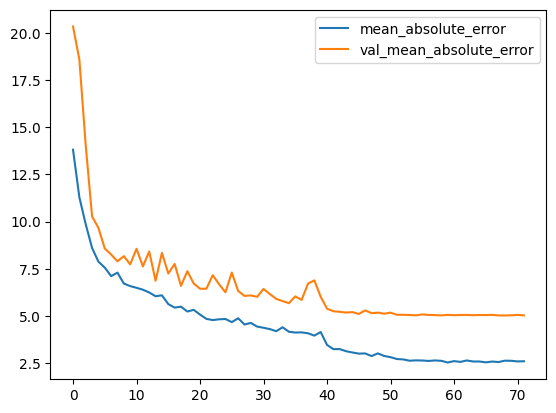

206/206 [==============================] - 27s 133ms/step - loss: 9.2222 - mean_absolute_error: 2.5983 - val_loss: 26.0668 - val_mean_absolute_error: 5.0302 - lr: 1.0000e-04
Epoch 73/100
206/206 [==============================] - ETA: 0s - loss: 8.7897 - mean_absolute_error: 2.5476
Epoch 73: val_mean_absolute_error did not improve from 5.02478


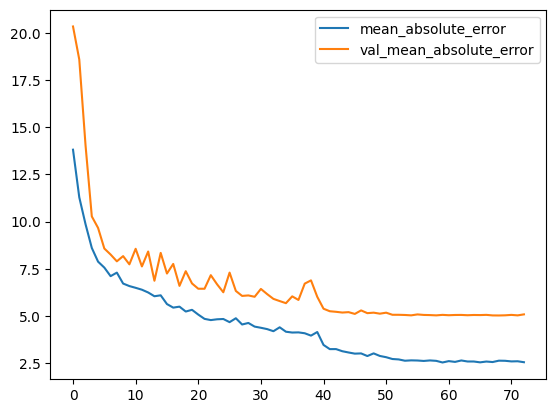

206/206 [==============================] - 27s 132ms/step - loss: 8.7897 - mean_absolute_error: 2.5476 - val_loss: 26.4024 - val_mean_absolute_error: 5.0831 - lr: 1.0000e-04
Epoch 74/100
206/206 [==============================] - ETA: 0s - loss: 9.2469 - mean_absolute_error: 2.5721
Epoch 74: val_mean_absolute_error did not improve from 5.02478


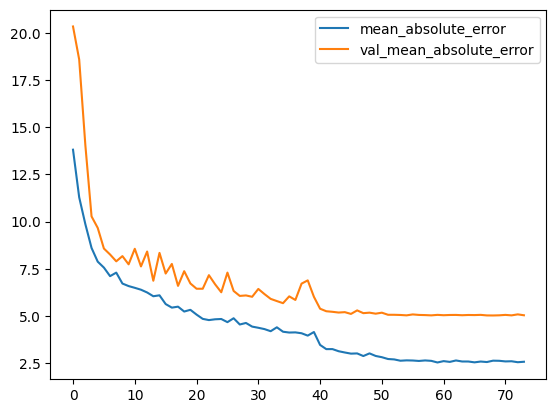

206/206 [==============================] - 27s 133ms/step - loss: 9.2469 - mean_absolute_error: 2.5721 - val_loss: 26.1029 - val_mean_absolute_error: 5.0357 - lr: 1.0000e-04
Epoch 75/100
206/206 [==============================] - ETA: 0s - loss: 9.3090 - mean_absolute_error: 2.5990
Epoch 75: val_mean_absolute_error did not improve from 5.02478


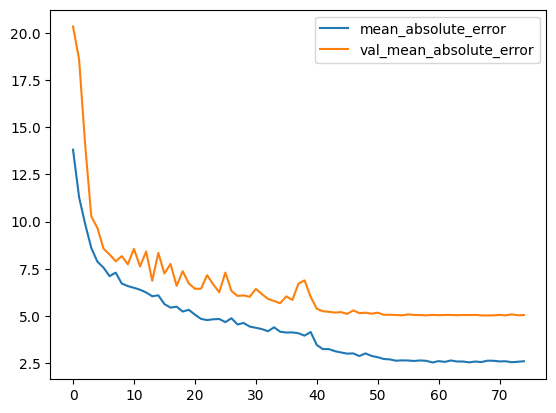

206/206 [==============================] - 27s 132ms/step - loss: 9.3090 - mean_absolute_error: 2.5990 - val_loss: 26.1337 - val_mean_absolute_error: 5.0480 - lr: 1.0000e-04
Epoch 76/100
206/206 [==============================] - ETA: 0s - loss: 8.9368 - mean_absolute_error: 2.5382
Epoch 76: val_mean_absolute_error did not improve from 5.02478


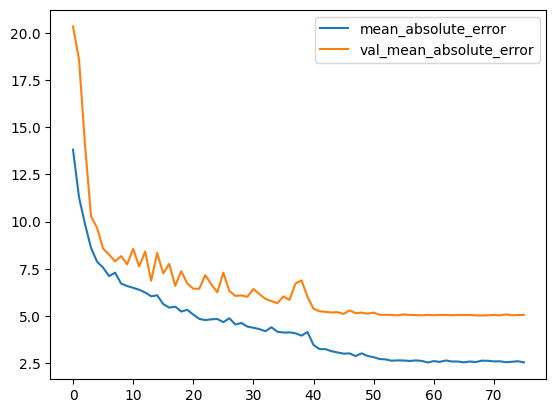

206/206 [==============================] - 28s 135ms/step - loss: 8.9368 - mean_absolute_error: 2.5382 - val_loss: 26.1207 - val_mean_absolute_error: 5.0542 - lr: 1.0000e-04
Epoch 77/100
206/206 [==============================] - ETA: 0s - loss: 9.2535 - mean_absolute_error: 2.6121
Epoch 77: val_mean_absolute_error improved from 5.02478 to 5.01865, saving model to temp3-from-sc.keras


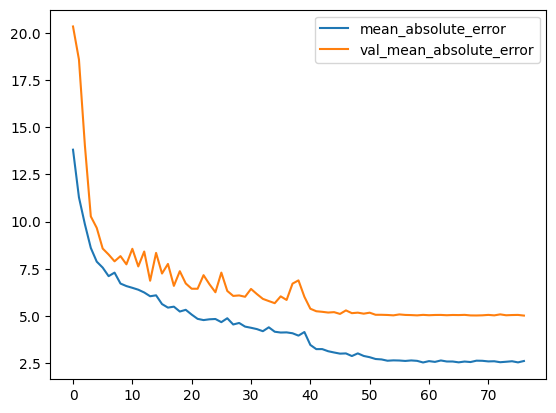

206/206 [==============================] - 26s 126ms/step - loss: 9.2535 - mean_absolute_error: 2.6121 - val_loss: 25.9546 - val_mean_absolute_error: 5.0187 - lr: 1.0000e-04
Epoch 78/100
206/206 [==============================] - ETA: 0s - loss: 8.9987 - mean_absolute_error: 2.5434
Epoch 78: val_mean_absolute_error did not improve from 5.01865


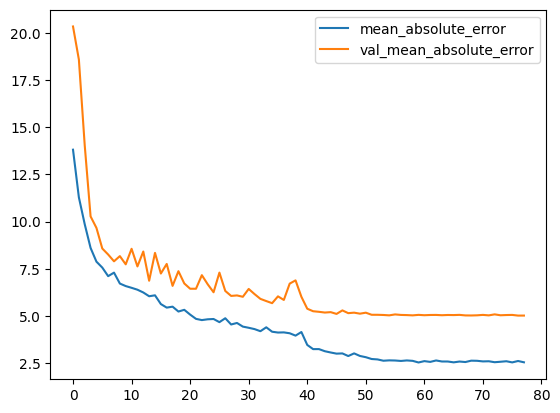

206/206 [==============================] - 26s 124ms/step - loss: 8.9987 - mean_absolute_error: 2.5434 - val_loss: 25.9146 - val_mean_absolute_error: 5.0195 - lr: 1.0000e-04
Epoch 79/100
206/206 [==============================] - ETA: 0s - loss: 9.3350 - mean_absolute_error: 2.6029
Epoch 79: val_mean_absolute_error did not improve from 5.01865


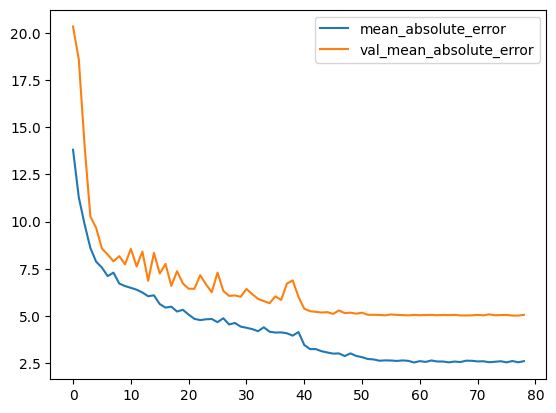

206/206 [==============================] - 26s 123ms/step - loss: 9.3350 - mean_absolute_error: 2.6029 - val_loss: 26.1314 - val_mean_absolute_error: 5.0579 - lr: 1.0000e-04
Epoch 80/100
206/206 [==============================] - ETA: 0s - loss: 8.8895 - mean_absolute_error: 2.5414
Epoch 80: val_mean_absolute_error did not improve from 5.01865


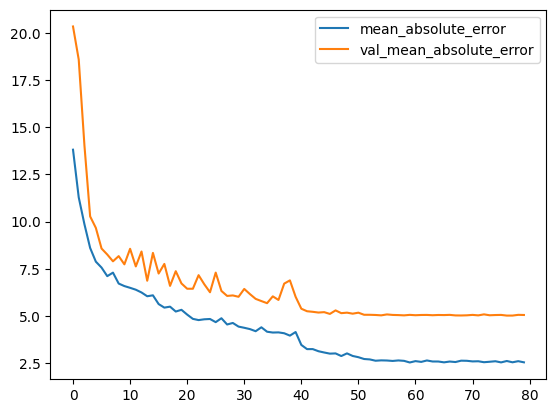

206/206 [==============================] - 25s 124ms/step - loss: 8.8895 - mean_absolute_error: 2.5414 - val_loss: 26.0938 - val_mean_absolute_error: 5.0507 - lr: 1.0000e-04
Epoch 81/100
206/206 [==============================] - ETA: 0s - loss: 8.6293 - mean_absolute_error: 2.4821
Epoch 81: val_mean_absolute_error did not improve from 5.01865


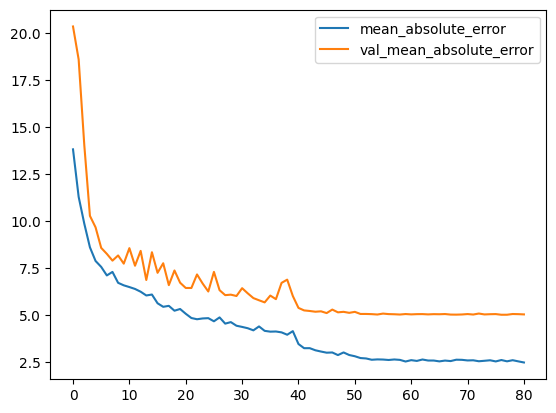

206/206 [==============================] - 26s 124ms/step - loss: 8.6293 - mean_absolute_error: 2.4821 - val_loss: 25.9926 - val_mean_absolute_error: 5.0372 - lr: 1.0000e-04
Epoch 82/100
206/206 [==============================] - ETA: 0s - loss: 9.1402 - mean_absolute_error: 2.5684
Epoch 82: val_mean_absolute_error improved from 5.01865 to 5.01484, saving model to temp3-from-sc.keras


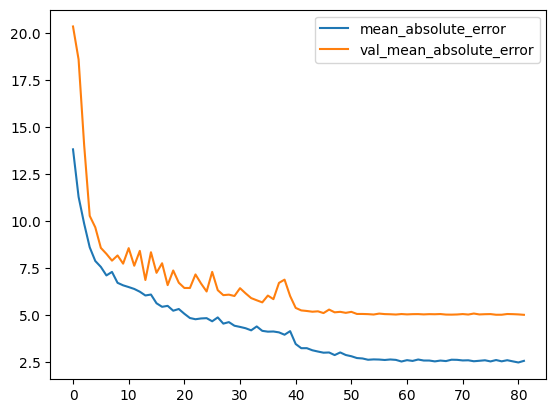

206/206 [==============================] - 26s 124ms/step - loss: 9.1402 - mean_absolute_error: 2.5684 - val_loss: 25.8576 - val_mean_absolute_error: 5.0148 - lr: 1.0000e-04
Epoch 83/100
206/206 [==============================] - ETA: 0s - loss: 8.8941 - mean_absolute_error: 2.5379
Epoch 83: val_mean_absolute_error did not improve from 5.01484


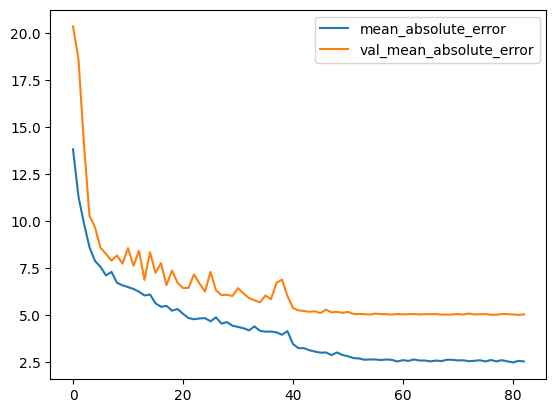

206/206 [==============================] - 26s 124ms/step - loss: 8.8941 - mean_absolute_error: 2.5379 - val_loss: 25.9891 - val_mean_absolute_error: 5.0350 - lr: 1.0000e-04
Epoch 84/100
206/206 [==============================] - ETA: 0s - loss: 8.9677 - mean_absolute_error: 2.5632
Epoch 84: val_mean_absolute_error did not improve from 5.01484


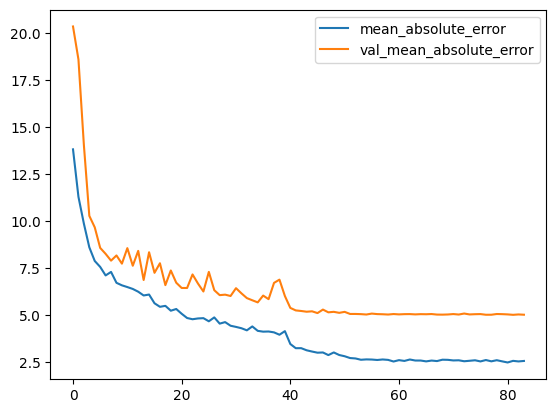

206/206 [==============================] - 26s 124ms/step - loss: 8.9677 - mean_absolute_error: 2.5632 - val_loss: 25.8988 - val_mean_absolute_error: 5.0203 - lr: 1.0000e-04
Epoch 85/100
206/206 [==============================] - ETA: 0s - loss: 8.6691 - mean_absolute_error: 2.5215
Epoch 85: val_mean_absolute_error did not improve from 5.01484


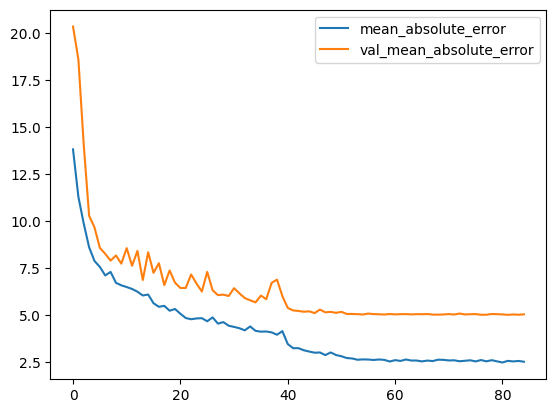

206/206 [==============================] - 25s 123ms/step - loss: 8.6691 - mean_absolute_error: 2.5215 - val_loss: 26.0282 - val_mean_absolute_error: 5.0390 - lr: 1.0000e-04
Epoch 86/100
206/206 [==============================] - ETA: 0s - loss: 8.7398 - mean_absolute_error: 2.4934
Epoch 86: val_mean_absolute_error did not improve from 5.01484


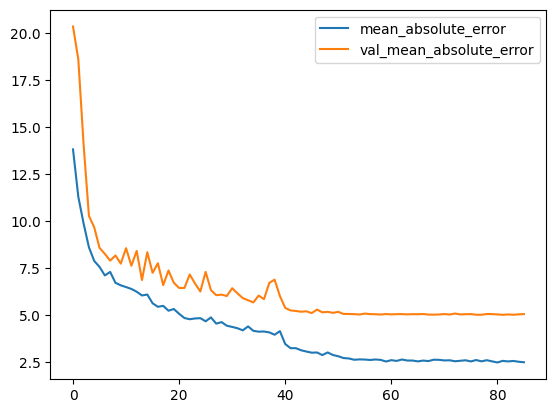

206/206 [==============================] - 26s 124ms/step - loss: 8.7398 - mean_absolute_error: 2.4934 - val_loss: 26.1523 - val_mean_absolute_error: 5.0533 - lr: 1.0000e-04
Epoch 87/100
206/206 [==============================] - ETA: 0s - loss: 8.9501 - mean_absolute_error: 2.5427
Epoch 87: val_mean_absolute_error did not improve from 5.01484


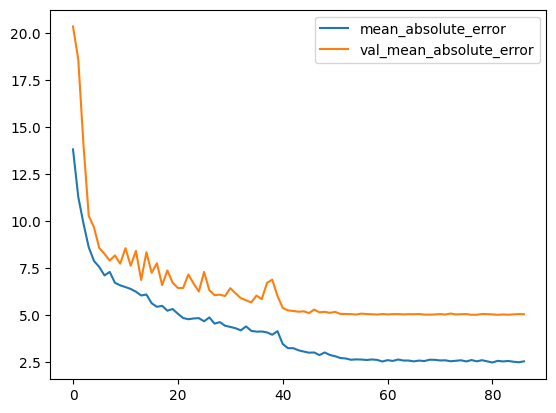

206/206 [==============================] - 26s 124ms/step - loss: 8.9501 - mean_absolute_error: 2.5427 - val_loss: 26.0481 - val_mean_absolute_error: 5.0468 - lr: 1.0000e-04
Epoch 88/100
206/206 [==============================] - ETA: 0s - loss: 8.7664 - mean_absolute_error: 2.5260
Epoch 88: val_mean_absolute_error did not improve from 5.01484


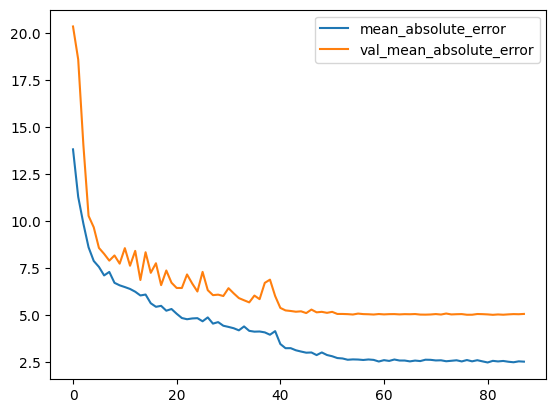

206/206 [==============================] - 26s 124ms/step - loss: 8.7664 - mean_absolute_error: 2.5260 - val_loss: 26.1212 - val_mean_absolute_error: 5.0623 - lr: 1.0000e-04
Epoch 89/100
206/206 [==============================] - ETA: 0s - loss: 8.6884 - mean_absolute_error: 2.4790
Epoch 89: val_mean_absolute_error did not improve from 5.01484


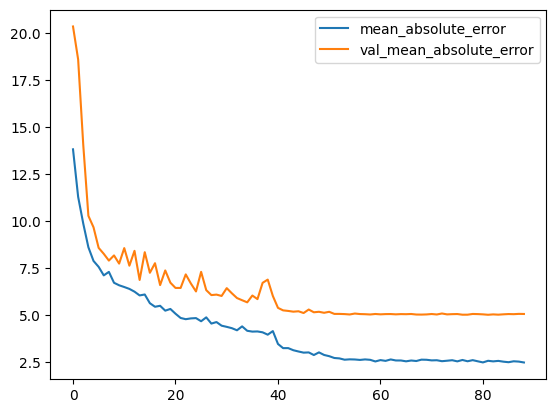

206/206 [==============================] - 26s 124ms/step - loss: 8.6884 - mean_absolute_error: 2.4790 - val_loss: 26.0372 - val_mean_absolute_error: 5.0576 - lr: 1.0000e-04
Epoch 90/100
206/206 [==============================] - ETA: 0s - loss: 8.7433 - mean_absolute_error: 2.5334
Epoch 90: val_mean_absolute_error did not improve from 5.01484


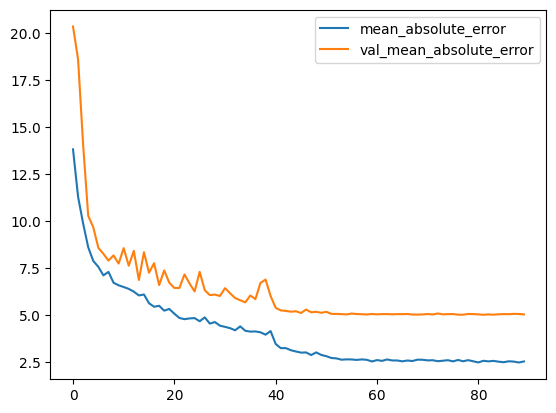

206/206 [==============================] - 25s 123ms/step - loss: 8.7433 - mean_absolute_error: 2.5334 - val_loss: 25.9185 - val_mean_absolute_error: 5.0342 - lr: 1.0000e-04
Epoch 91/100
206/206 [==============================] - ETA: 0s - loss: 8.5692 - mean_absolute_error: 2.4712
Epoch 91: val_mean_absolute_error did not improve from 5.01484


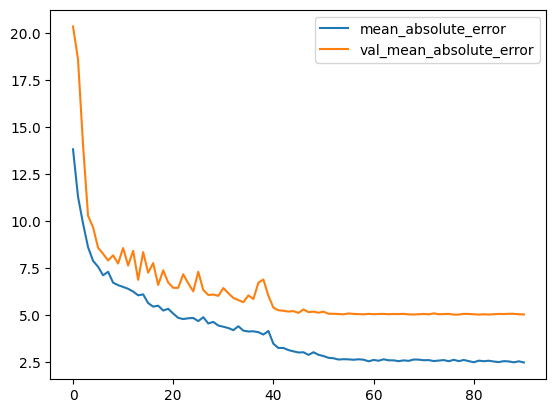

206/206 [==============================] - 26s 124ms/step - loss: 8.5692 - mean_absolute_error: 2.4712 - val_loss: 25.9367 - val_mean_absolute_error: 5.0252 - lr: 1.0000e-04
Epoch 92/100
206/206 [==============================] - ETA: 0s - loss: 8.7783 - mean_absolute_error: 2.5196
Epoch 92: val_mean_absolute_error did not improve from 5.01484


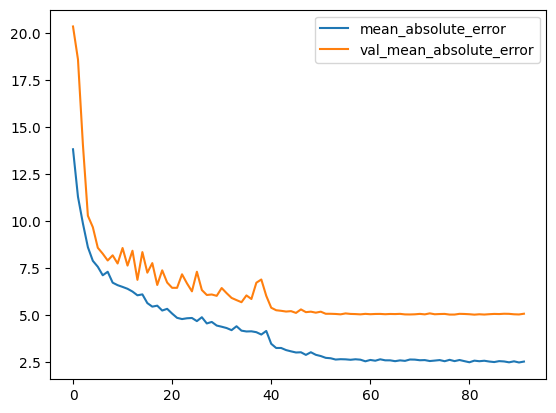

206/206 [==============================] - 26s 124ms/step - loss: 8.7783 - mean_absolute_error: 2.5196 - val_loss: 26.1602 - val_mean_absolute_error: 5.0637 - lr: 1.0000e-04
Epoch 93/100
206/206 [==============================] - ETA: 0s - loss: 8.5947 - mean_absolute_error: 2.4889
Epoch 93: val_mean_absolute_error did not improve from 5.01484


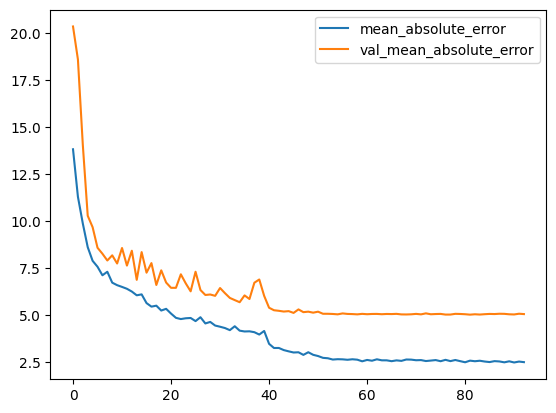

206/206 [==============================] - 26s 124ms/step - loss: 8.5947 - mean_absolute_error: 2.4889 - val_loss: 26.0039 - val_mean_absolute_error: 5.0447 - lr: 1.0000e-04
Epoch 94/100
206/206 [==============================] - ETA: 0s - loss: 8.4993 - mean_absolute_error: 2.4849
Epoch 94: val_mean_absolute_error did not improve from 5.01484


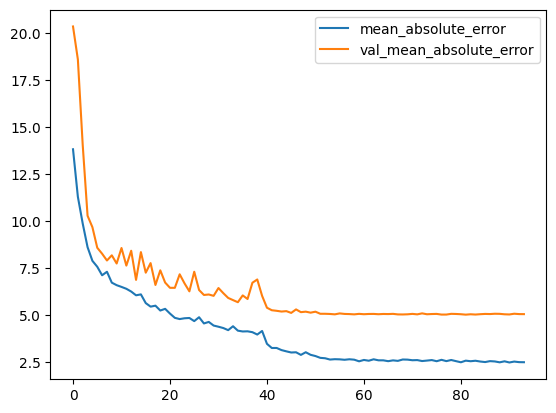

206/206 [==============================] - 25s 124ms/step - loss: 8.4993 - mean_absolute_error: 2.4849 - val_loss: 25.9940 - val_mean_absolute_error: 5.0422 - lr: 1.0000e-04
Epoch 95/100
206/206 [==============================] - ETA: 0s - loss: 8.8015 - mean_absolute_error: 2.5094
Epoch 95: val_mean_absolute_error did not improve from 5.01484


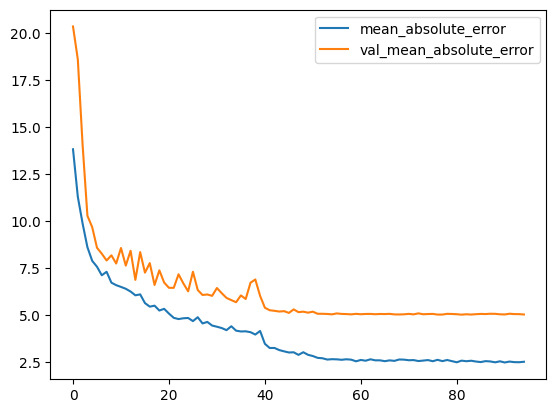

206/206 [==============================] - 25s 123ms/step - loss: 8.8015 - mean_absolute_error: 2.5094 - val_loss: 25.8752 - val_mean_absolute_error: 5.0234 - lr: 1.0000e-04
Epoch 96/100
206/206 [==============================] - ETA: 0s - loss: 8.5409 - mean_absolute_error: 2.5009
Epoch 96: val_mean_absolute_error improved from 5.01484 to 5.00578, saving model to temp3-from-sc.keras


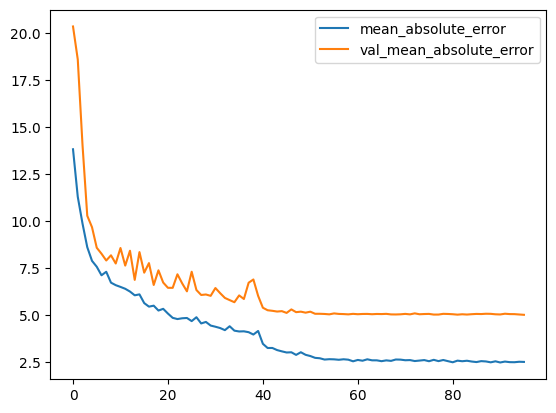

206/206 [==============================] - 26s 124ms/step - loss: 8.5409 - mean_absolute_error: 2.5009 - val_loss: 25.7426 - val_mean_absolute_error: 5.0058 - lr: 1.0000e-04
Epoch 97/100
206/206 [==============================] - ETA: 0s - loss: 8.9646 - mean_absolute_error: 2.5553
Epoch 97: val_mean_absolute_error did not improve from 5.00578


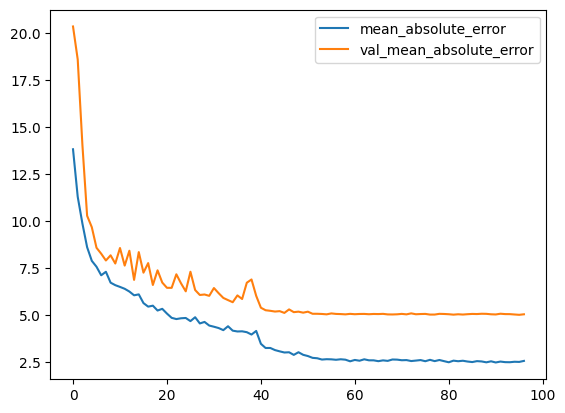

206/206 [==============================] - 26s 125ms/step - loss: 8.9646 - mean_absolute_error: 2.5553 - val_loss: 25.9771 - val_mean_absolute_error: 5.0342 - lr: 1.0000e-04
Epoch 98/100
206/206 [==============================] - ETA: 0s - loss: 8.6893 - mean_absolute_error: 2.5008
Epoch 98: val_mean_absolute_error did not improve from 5.00578


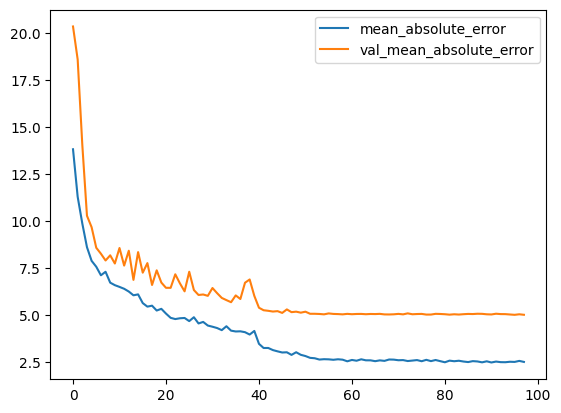

206/206 [==============================] - 26s 124ms/step - loss: 8.6893 - mean_absolute_error: 2.5008 - val_loss: 25.8276 - val_mean_absolute_error: 5.0076 - lr: 1.0000e-04
Epoch 99/100
206/206 [==============================] - ETA: 0s - loss: 8.4529 - mean_absolute_error: 2.4723
Epoch 99: val_mean_absolute_error did not improve from 5.00578


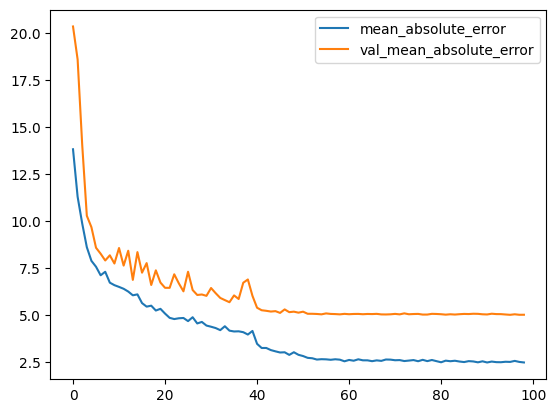

206/206 [==============================] - 26s 124ms/step - loss: 8.4529 - mean_absolute_error: 2.4723 - val_loss: 25.8678 - val_mean_absolute_error: 5.0094 - lr: 1.0000e-04
Epoch 100/100
206/206 [==============================] - ETA: 0s - loss: 8.5305 - mean_absolute_error: 2.4708
Epoch 100: val_mean_absolute_error did not improve from 5.00578


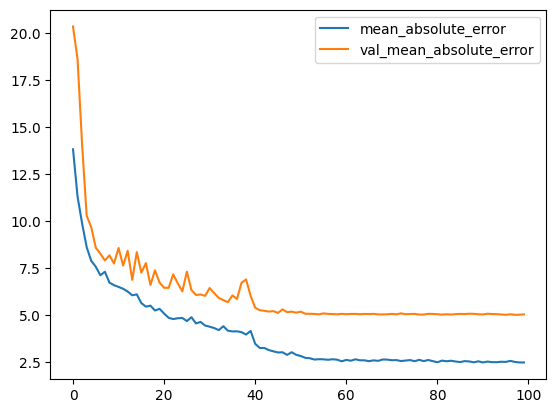

206/206 [==============================] - 26s 124ms/step - loss: 8.5305 - mean_absolute_error: 2.4708 - val_loss: 25.9544 - val_mean_absolute_error: 5.0282 - lr: 1.0000e-04


In [10]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-4)

# Train the Model
train_generator.reset()
model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, reduce_lr, plot_losses],
)

In [1]:
from keras.models import load_model

# Test Model
model = load_model("temp4-from-sc.keras")
model.summary(show_trainable=True)

2024-03-27 08:56:52.774544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 08:56:52.774613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 08:56:52.775555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 08:56:52.781752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 08:56:53.805674: W tensorflow/compiler/tf2

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 460, 760, 3)]     0         Y          
                                                                            
 conv2d_4 (Conv2D)           (None, 460, 760, 64)      4864      Y          
                                                                            
 batch_normalization_4 (Bat  (None, 460, 760, 64)      256       Y          
 chNormalization)                                                           
                                                                            
 max_pooling2d_4 (MaxPoolin  (None, 230, 380, 64)      0         Y          
 g2D)                                                                       
                                                                            
 conv2d_5 (Conv2D)           (None, 230, 380, 32)      5123

In [2]:
validation_generator.reset()
predict = model.predict(
    x=validation_generator,
    steps=len(validation_generator),
    workers=1,
    use_multiprocessing=False,
)

val_set = validation_set.copy()
val_set["meat"] = predict[:, 0]
val_set["veggie"] = predict[:, 1]
val_set["noodle"] = predict[:, 2]
val_set.compare(validation_set)

NameError: name 'validation_generator' is not defined

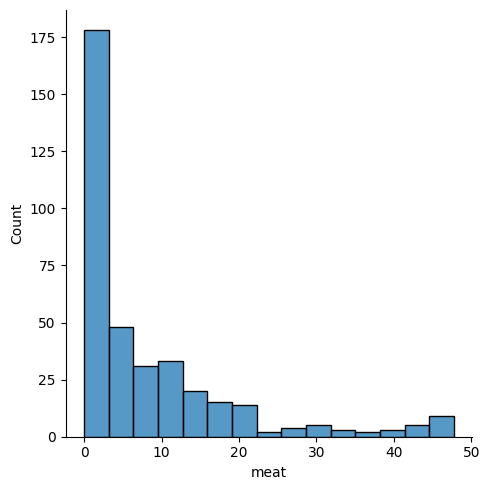

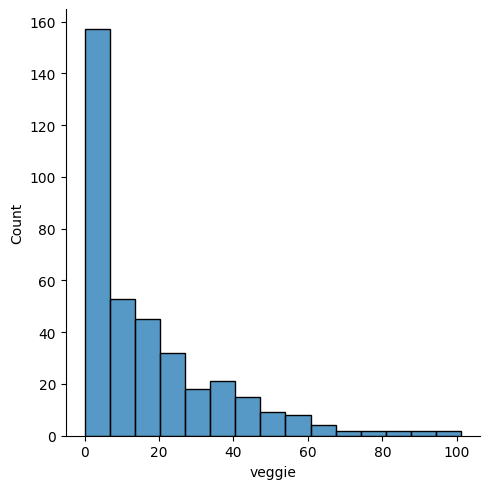

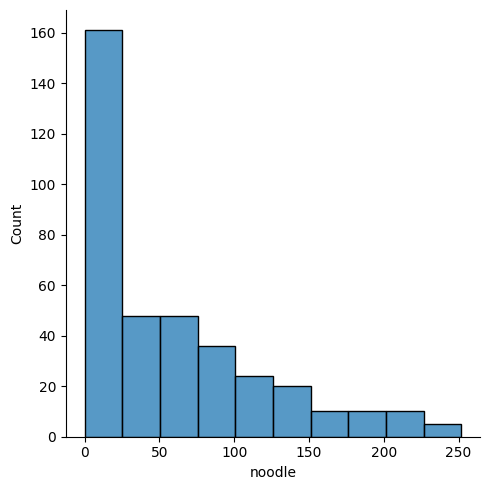

In [40]:
import seaborn as sns

sns.displot(val_set, x="meat")
sns.displot(val_set, x="veggie")
sns.displot(val_set, x="noodle")

In [41]:
(val_set["meat"] - validation_set["meat"]).abs().mean()

2.186112465076549

In [42]:
(val_set["veggie"] - validation_set["veggie"]).abs().mean()

2.914780124541252

In [43]:
(val_set["noodle"] - validation_set["noodle"]).abs().mean()

6.176626474065806

In [36]:
checkpoint = ModelCheckpoint(
    "temp4-from-sc.keras",
    verbose=1,
    monitor="mean_absolute_error",
    save_best_only=True,
    mode="min",
)

model.compile(
    optimizer=Adam(learning_rate = 5e-4), 
    loss=keras.losses.Huber(delta=10.0, reduction="sum_over_batch_size", name="huber_loss"), 
    metrics=['mean_absolute_error']
)

validation_generator.reset()
model.fit(
    x=validation_generator,
    steps_per_epoch=len(validation_generator),
    epochs=10,
    callbacks=[checkpoint],
)

Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 24.4321 - mean_absolute_error: 4.8521
Epoch 1: mean_absolute_error improved from inf to 4.85208, saving model to temp4-from-sc.keras
12/12 [==============================] - 7s 409ms/step - loss: 24.4321 - mean_absolute_error: 4.8521
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 22.9798 - mean_absolute_error: 4.6297
Epoch 2: mean_absolute_error improved from 4.85208 to 4.62967, saving model to temp4-from-sc.keras
12/12 [==============================] - 5s 397ms/step - loss: 22.9798 - mean_absolute_error: 4.6297
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 21.8832 - mean_absolute_error: 4.4746
Epoch 3: mean_absolute_error improved from 4.62967 to 4.47456, saving model to temp4-from-sc.keras
12/12 [==============================] - 5s 409ms/step - loss: 21.8832 - mean_absolute_error: 4.4746
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 20.9922 - mean_abs